In [1]:
# Let's import the needed packages
# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# To plot the map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# To perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.model_selection import train_test_split

# To import the models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA

# 0. Useful functions

In this part, we define several functions that will be used along the notebook. Please return to this section for any need of clarification.

In [2]:
############# DATA PREPROCESSING ###############
def split_scale_data(X, y, RANDOM_SPLIT=False, train_size=374, verbose=True, scale=True):
    """
    X, y: Inputs and outputs
    RANDOM_SPLIT: Boolean, if False splits for train and test are done in in time order, if True, splits are random
    train_size: number of data in the train sample (test_size=474 - train_size)
    verbose: if True, the function prints information about the shape of the outputs data sets
    scale: if True, data are scaled
    """
    # Split the data
    if RANDOM_SPLIT:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    if scale:
        # Introduce a scaler
        scaler = StandardScaler()
        scaler.fit(X_train)
        # Standardize the train and test data
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    # Check dimensions
    if verbose:
        print("==== SPLIT & SCALE THE DATA ====")
        print("Shape of X_train:", X_train.shape)
        print("Shape of y_train:", y_train.shape)
        print("Shape of X_test:", X_test.shape)
        print("Shape of y_test:", y_test.shape)

    return(X_train, X_test, y_train, y_test)


############# VALIDATION FUNCTION FOR LASSO OR RIDGE ###############
def validation(X_train, y_train, X_validation, y_validation, low_power, high_power, nb_points, Ridge=True):
    """
    Function to perform hyper parameter tuning for the Ridge and Lasso models
    Inputs:
    X_train, y_train, X_validation, y_validation: input data 
    low_power, high_power, nb_points: floats to chose the range and number of lambda parameter to evaluate
    Ridge: Bool to precise to the function if the model is Ridge or Lasso 
    Outputs: 
    max_param: parameter of the model which performs the best on the test set
    max_accuracy_validation: the best test accuracy reached 
    train_accuracy: the train accuracy of the model which performs the best on the test set
    parameter_values: list of the parameters of each model trained 
    coefficients: coefficients of the model which performs the best on the test set
    accuracy_train_cv_list: list of train accuracies of the model trained with different parameters
    accuracy_valid_list: list of test accuracies of the model trained with different parameters
    """
    # Hyperparameter tuning: Evaluate different lambda (regularization strength) values
    parameter_values = np.logspace(low_power, high_power, nb_points)


    accuracy_train_cv_list = []
    accuracy_valid_list = []
    coefficients = []

    for param in parameter_values:
        if Ridge:
            classifier = RidgeClassifier(alpha = param)
            classifier.fit(X_train, y_train)
        else:
            classifier = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = param)
            classifier.fit(X_train, y_train)

        # Store accuracies for training and validation data
        accuracy_train_cv_list.append(classifier.score(X_train, y_train))
        accuracy_valid_list.append(classifier.score(X_validation, y_validation))

        # Store coefficients
        coefficients.append(classifier.coef_)

    coefficients = np.array(coefficients)

    # Find the lambda value that maximizes validation accuracy
    max_accuracy_index = np.argmax(accuracy_valid_list)
    max_param = parameter_values[max_accuracy_index]
    max_accuracy_validation = accuracy_valid_list[max_accuracy_index]
    train_accuracy = accuracy_train_cv_list[max_accuracy_index]

    print(f"Best parameter value after validation: {max_param:.1f}")
    print(f"Accuracy for training: {train_accuracy:.3f}")
    print(f"Accuracy for validation: {max_accuracy_validation:.3f}")

    return max_param, max_accuracy_validation, train_accuracy, parameter_values, coefficients, accuracy_train_cv_list, accuracy_valid_list


############# EVALUATION FUNCTION FOR ALL MODELS ###############
def test_model(model_to_test, X_train, X_test, y_train, y_test, verbose=True):
    """
    Function to evaluate each model we selected, print the train and test performances and the confusion matrix
    Inputs: 
    model_to_test: the model we want to evaluate 
    X_train, X_test, y_train, y_test: input data
    verbose: boolean to say if we want to print information about the evaluation or just return the results 
    Outputs: 
    accuracy_score_test, roc_auc_score_test the scores of the model on the test set 

    """
    # Define the classifier
    model = model_to_test

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # For Ridge and Lasso, the computation of the AUC is different, we split the cases in 2: models Ridge and Lasso and the others
    if str(type(model)) == "<class 'sklearn.linear_model._ridge.RidgeClassifier'>" or str(type(model)) == "<class 'sklearn.linear_model._logistic.LogisticRegression'>":
        # Decision values for AUC computation
        train_decision_values = model.decision_function(X_train)
        test_decision_values = model.decision_function(X_test)
        # Compute scores
        accuracy_score_train = accuracy_score(y_train, y_train_pred)
        roc_auc_score_train = roc_auc_score(y_train, train_decision_values)
        accuracy_score_test = accuracy_score(y_test, y_test_pred)
        roc_auc_score_test = roc_auc_score(y_test, test_decision_values)

    else:
        # Computation of the AUC and accuracy
        roc_auc_score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        accuracy_score_train = accuracy_score(y_train, y_train_pred)

        roc_auc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        accuracy_score_test = accuracy_score(y_test, y_test_pred)

    if verbose:
        # Print the results
        print("==== TRAIN ====")
        print(f"Accuracy for TRAIN data: {accuracy_score_train:.3f}")
        print(f"     AUC for TRAIN data: {roc_auc_score_train:.3f}")

        print("==== TEST ====")
        print(f"Accuracy for TEST data: {accuracy_score_test:.3f}")
        print(f"     AUC for TEST data: {roc_auc_score_test:.3f}")

        # Compute the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_test_pred)

        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix - Model: {model}")

    return accuracy_score_test, roc_auc_score_test

############# VALIDATION FUNCTION FOR PCA DIMENSIONS ###############
def validation_PCA(X_train_cv, y_train_cv, X_validation, y_validation, model, dim_max, verbose = True): 
    """ 
    Pipeline for validation of the parameter p of PCA for dimensionality reduction 
    Inputs: 
    X_train_cv, y_train_cv, X_validation, y_validation: input data 
    model: the model we want to test in combination with PCA 
    dim_max: controls the maximal number of dimnesions we want to do PCA with 
    verbose: boolean to say if we want to print information about the cross-validation or just return the results
    Outputs: 
    best_p_value: dimension on which the model performs the best on the test set 
    best_test_score_pca: best accuracy achieved on the test set 

    """
    
    p_values = np.linspace(1, dim_max, dim_max).astype(int)
    p_values = p_values.astype(int)
    test_score_accuracy = []
    train_score_accuracy = []
    
    for p in p_values:
        
        # PCA with p principal components
        pca = PCA(n_components = p)
        pca.fit(X_train_cv)

        # Project data
        X_train_projected = pca.transform(X_train_cv)
        X_validation_projected = pca.transform(X_validation)

        model.fit(X_train_projected, y_train_cv)

        # Get the prediction
        y_val_pred = model.predict(X_validation_projected)
        y_train_pred = model.predict(X_train_projected)

        # Computation of the accuracy
        test_score_accuracy.append(accuracy_score(y_validation, y_val_pred))
        train_score_accuracy.append(accuracy_score(y_train_cv, y_train_pred))

    # Get the best score
    best_index = np.argsort(-np.array(test_score_accuracy))[0]
    best_p_value = p_values[best_index]
    best_test_score_pca = test_score_accuracy[best_index]
    best_train_score_pca = train_score_accuracy[best_index]

    if verbose: 
        print(f"Best value of p - PCA : {best_p_value}")
        print(f"Train Score for the best p: {best_train_score_pca}")
        print(f"Test Score for the best p: {best_test_score_pca}")
        
        # Plot the validation curve
        plt.figure(figsize = [9,6])
        plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
        plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
        plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
        plt.title("Evolution of the accuracy according to the value p: Number of Principal Components for PCA")
        plt.xlabel("Number of Principal Components")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()

    return best_p_value, best_test_score_pca


############# PLOT COMPARISIONS BETWEEN MODELS ###############
def plot_score(model_names, auc_scores, accuracy_scores):
    """plots histograms to have a visual representation of scores from different models 
    Inputs: 
    models_names: list of model names to plot on the graph 
    auc_scores: list of auc of the corresponding models 
    accuracy_scores: list of accuracies of the corresponding models 
    """
    x = np.arange(len(model_names))
    fig, ax = plt.subplots(figsize = (12, 7))

    #plot the histograms of accuracy and auc 
    auc_bars = ax.bar(x - 0.175, auc_scores, 0.35, label = 'AUC', color = 'skyblue')
    accuracy_bars = ax.bar(x + 0.175, accuracy_scores, 0.35, label = 'Accuracy', color = 'lightcoral')

    #plot horizontal lines for the highest accuracy and auc
    max_auc = max(auc_scores)
    max_accuracy = max(accuracy_scores)
    ax.hlines(y = max_auc, xmin = -0.5, xmax = len(model_names)-0.5, colors = 'skyblue', linestyles = '--', linewidth = 1.5) 
    ax.hlines(y = max_accuracy, xmin = -0.5, xmax = len(model_names)-0.5, colors = 'lightcoral', linestyles = '--', linewidth = 1.5)  
    ax.text(len(model_names)-0.5, max_auc + 0.02, f'Best AUC: {max_auc:.3f}', color='skyblue', ha='right')
    ax.text(len(model_names)-0.5, max_accuracy + 0.02, f'Best Accuracy: {max_accuracy:.3f}', color='lightcoral', ha='right')

    ax.set_xlabel('Model')
    ax.set_ylabel('Scores')
    ax.set_ylim(0, 1)
    ax.set_title('AUC and Accuracy Scores of Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation = 45, ha = 'right')
    ax.set_xticklabels(model_names)
    ax.legend()

    #annotations for the value of each bar
    for bar in auc_bars + accuracy_bars:
        ax.annotate(f'{bar.get_height():.3f}', 
                    xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    xytext = (0, 3), 
                    textcoords = "offset points",
                    ha = 'center', va = 'bottom')

    plt.show()


# I) Preprocessing and Labelling Data

First, let's get to know the data: 

In [3]:
# Data path
sst_data_path = 'data/sst.mnmean.nc'

# Upload the data under a xr array format
sst_ds = xr.open_dataset(sst_data_path)

# To check the data Structure
# print(sst_ds)

# To plot the dimensions and attributes of the data 
#sst_ds.info()

#Let's verify that there is no NaN in our dataset 
nan_count = np.isnan(sst_ds).sum()
print(f"Number of NaNs in sst_ds : {nan_count}")

Number of NaNs in sst_ds : <xarray.Dataset> Size: 16B
Dimensions:    ()
Data variables:
    sst        int64 8B 0
    time_bnds  int64 8B 0


Great ! There are no NaNs in the dataset so we don't have to deal with data imputation. 

Now let's restrict our study to a small zone in the Pacific to label El Nino Events.

## I) 1) Label the data 

In [4]:
# Now we have to restrict the zone to study and label the El-Nino temperature anomalies
# https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_advisory/enso-alert-readme.shtml#:~:text=The%20Climate%20Prediction%20Center%20defines...%20%22El%20Ni%C3%B1o%20conditions%22,Ni%C3%B1o%20Index%20%28ONI%29%20threshold%20will%20be%20met%2C%20AND
# Niño 3.4 Zone(5°N-5°S, 170°W-120°W)

#Latitudes: convert 5°N-5°S to the format [-90°, 90°] N->S
nino_lat_min = -5  
nino_lat_max = 5   

# Longitudes : convert 170°W and 120°W to the format [0°E, 360°E]
# 170°W = 360 - 170 = 190°E
# 120°W = 360 - 120 = 240°E
nino_lon_min = 190
nino_lon_max = 240

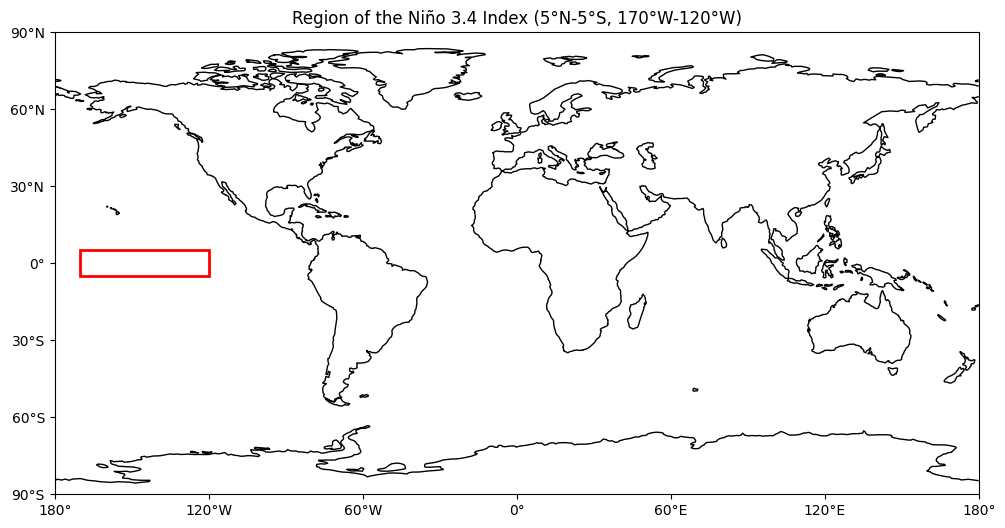

In [5]:
# Let's vizualize the Nino 3.4 zone 
plt.figure(figsize = [12, 6])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

# Define the box of the restricted area 
nino34_box = patches.Rectangle(xy = [nino_lon_min, nino_lat_min], width = nino_lon_max - nino_lon_min, height = nino_lat_max - nino_lat_min, linewidth = 2, edgecolor = 'red', facecolor = 'none', transform = ccrs.PlateCarree())
ax.add_patch(nino34_box)

# Add Labels and Title
ax.set_xticks(range(-180, 181, 60), crs = ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 30), crs = ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.title("Region of the Niño 3.4 Index (5°N-5°S, 170°W-120°W)")
plt.savefig("images/El_Nino_Index_3.4.png")

plt.show()

In [6]:
#Let's now focus on the temperature variation on the Nino 3.4 zone 

# We define the Nino 3.4 region 
nino34_zone = sst_ds.sst.where(
    (sst_ds.lat >= nino_lat_min) & (sst_ds.lat <= nino_lat_max) &
    (sst_ds.lon >= nino_lon_min) & (sst_ds.lon <= nino_lon_max), drop=True #drops data outside of the box
)

# We average data on the Nino 3.4 zone and substract the temporal mean to establish a baseline
nino_sst_anomaly = nino34_zone.mean(dim = ["lat", "lon"]) - nino34_zone.mean(dim = ["lat", "lon"]).mean(dim = "time")

# Compute the Nino events 
nino_events = nino_sst_anomaly.where(nino_sst_anomaly >= 0.5, drop = True) 
nino_months = pd.to_datetime(nino_events.time.values)

# print("Dates of the El Nino Events:", nino_months)
# print(nino_sst_anomaly)

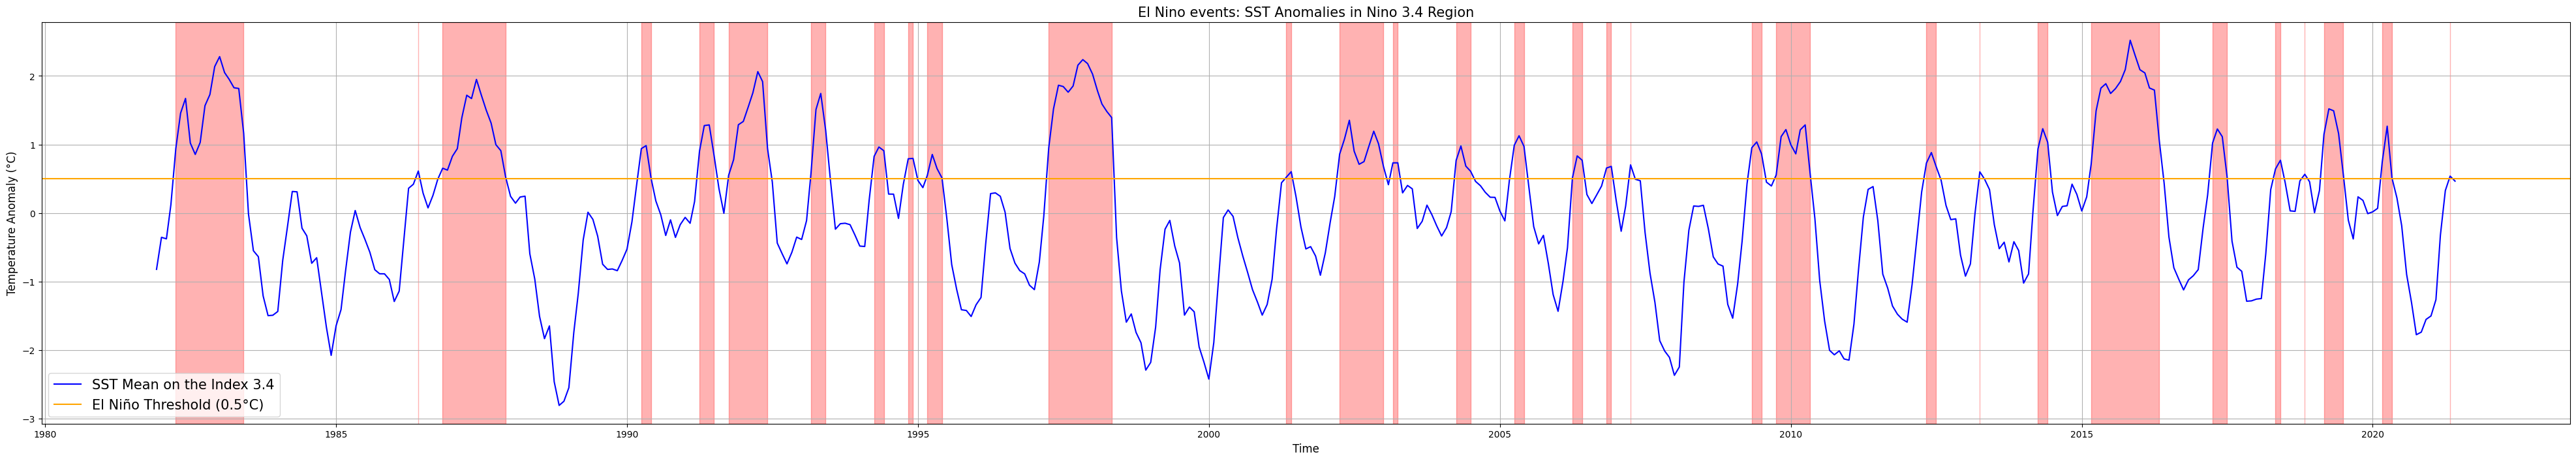

In [7]:
# Let's visualize the Nino Events 
plt.figure(figsize = [50, 8])
nino_sst_anomaly.plot(label = "SST Mean on the Index 3.4", color = "blue")

el_nino_periods = (nino_sst_anomaly >= 0.5).astype(int)

# Find the transitions between neutral and non-nino
transitions = np.diff(el_nino_periods, prepend = 0, append = 0)
start_indices = np.where(transitions == 1)[0]  # Beginning of a Nino phase
end_indices = np.where(transitions == -1)[0]  # End of a Nino phase 

# Add a color to show the Nino periods
for start, end in zip(start_indices, end_indices):
    plt.axvspan(nino_sst_anomaly.time[start].values, nino_sst_anomaly.time[end - 1].values, color = 'red', alpha = 0.3)

# Show the decision threshold
plt.axhline(0.5, color = 'orange', label = "El Niño Threshold (0.5°C)")

# Add Titles and legends
plt.title("El Nino events: SST Anomalies in Nino 3.4 Region", fontsize = 15)
plt.xlabel("Time", fontsize = 12)
plt.ylabel("Temperature Anomaly (°C)", fontsize = 12)
plt.legend(fontsize = 15)
plt.grid(True)

# Save the graph
plt.savefig("images/Temperatures_anomalies.png")
plt.show()

In [8]:
# Let's create our dataset for the prediction 1 month in advance
# We have to suppress the First and the Last month of the original dataset
all_months = pd.to_datetime(nino_sst_anomaly.time.values)

# Let's create y: assign 1 if there is a El Nino event in the following month, 0 otherwise 
y_1m = []
for i in range(0, len(all_months) - 1): 
    next_month = all_months[i + 1]
    if next_month in nino_months:
        y_1m.append(1)
    else:
        y_1m.append(0)

y_1m = np.array(y_1m)

# Let's create X: extract the SST data for all valid months
sst_global_data = sst_ds.sst.sel(time = slice(all_months[0], all_months[-2]))
X_1m = sst_global_data.values.reshape(len(all_months) - 1, -1)  #Flatten the data by month 

# Verify that the size are correct 
print(X_1m.shape, y_1m.shape)

#Save the data under the format .npz (optional)
# np.savez_compressed("data/preprocessed_data/nino_dataset_1m.npz", X=X_1m, y=y_1m)

(474, 64800) (474,)


Now let's automatize the process, so that we have the data for N months in advance.

In [9]:
def get_data_N_month_in_advance(N):
    # Prediction N months in advance
    # We have to suppress the last three months of the original dataset
    y_m = []
    for i in range(0, len(all_months) - N):  # Stop N months before the end
        next_3_months = all_months[i + N]
        if next_3_months in nino_months:
            y_m.append(1)
        else:
            y_m.append(0)

    y_m = np.array(y_m)

    # Extract SST data for all valid months, excluding the last three months
    sst_global_data_m = sst_ds.sst.sel(time = slice(all_months[0], all_months[-(N+1)]))
    X_m = sst_global_data_m.values.reshape(len(all_months) - N, -1)  # Flatten the data by month

    # Save the dataset (optional)
    # np.savez_compressed(f"data/preprocessed_data/nino_dataset_{N}m.npz", X = X_m, y = y_m)
    return(X_m, y_m)


datasets = {1: {'X': X_1m, 'y': y_1m}}

for i in range(2, 13):
    X_m, y_m = get_data_N_month_in_advance(i)
    datasets[i] = {'X': X_m, 'y': y_m}  

# Verify the size of the stored data
for key, value in datasets.items():
    print(f"Prediction {key} months in advance:")
    print(f"X shape: {value['X'].shape}, y shape: {value['y'].shape}")

Prediction 1 months in advance:
X shape: (474, 64800), y shape: (474,)
Prediction 2 months in advance:
X shape: (473, 64800), y shape: (473,)
Prediction 3 months in advance:
X shape: (472, 64800), y shape: (472,)
Prediction 4 months in advance:
X shape: (471, 64800), y shape: (471,)
Prediction 5 months in advance:
X shape: (470, 64800), y shape: (470,)
Prediction 6 months in advance:
X shape: (469, 64800), y shape: (469,)
Prediction 7 months in advance:
X shape: (468, 64800), y shape: (468,)
Prediction 8 months in advance:
X shape: (467, 64800), y shape: (467,)
Prediction 9 months in advance:
X shape: (466, 64800), y shape: (466,)
Prediction 10 months in advance:
X shape: (465, 64800), y shape: (465,)
Prediction 11 months in advance:
X shape: (464, 64800), y shape: (464,)
Prediction 12 months in advance:
X shape: (463, 64800), y shape: (463,)


In [10]:
# Let's compare our results with the results from NOAA 
# "https://psl.noaa.gov/data/correlation/nina34.anom.data"

# Transform the anomalies as a dataframe
nino_sst_anomaly_df = nino_sst_anomaly.to_dataframe().reset_index()
nino_sst_anomaly_df = nino_sst_anomaly_df.rename(columns = {nino_sst_anomaly.name: "anomaly_calculated"})

# Load the NOAA data file and parse it
noaa_data_url = "https://psl.noaa.gov/data/correlation/nina34.anom.data"
noaa_data = pd.read_csv(noaa_data_url, sep= r'\s+', skiprows = 1, header = None)

years = noaa_data.iloc[:-3, 0].astype(int) 
months_data = noaa_data.iloc[:-3, 1:]  

# Transform the data into time series
dates = pd.date_range(start = f"{years.min()}-01", periods = len(years) * 12, freq = "M")
noaa_series = pd.DataFrame({"time": dates, "anomaly_noaa": months_data.values.flatten()}).dropna()

# Restrict the datetime of NOAA dataset to the dates of SST anomalies
# (We substract a month because noaa goes from 31th of each month to 31th of each month and our datatset goes from 1st of each month to 1st of each month)
start_date = pd.to_datetime(nino_sst_anomaly.time.min().values) - pd.DateOffset(months=1) 
end_date = pd.to_datetime(nino_sst_anomaly.time.max().values)

# Filter the NOAA data
noaa_series_common = noaa_series[(noaa_series["time"] >= start_date) & (noaa_series["time"] <= end_date)]

#Let's check that the time period is the same 
print(f"Time of NOAA Data: {noaa_series_common['time'].min()} to {noaa_series_common['time'].max()}")
print(f"Time of our SST Data: {nino_sst_anomaly_df['time'].min()} to {nino_sst_anomaly_df['time'].max()}")

Time of NOAA Data: 1981-11-30 00:00:00 to 2021-05-31 00:00:00
Time of our SST Data: 1981-12-01 00:00:00 to 2021-06-01 00:00:00


C:\Users\Audrey Airaud\AppData\Local\Temp\ipykernel_1972\2521396040.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start = f"{years.min()}-01", periods = len(years) * 12, freq = "M")


In [11]:
noaa_series_common["anomaly_noaa"] = pd.to_numeric(noaa_series_common["anomaly_noaa"], errors = "coerce")
nino_sst_anomaly_df["anomaly_calculated"] = pd.to_numeric(nino_sst_anomaly_df["anomaly_calculated"], errors = "coerce")

#Let's compute the correlation between the two datasets
correlation = np.corrcoef(noaa_series_common["anomaly_noaa"], nino_sst_anomaly_df["anomaly_calculated"])[0, 1]
print(f"Correlation between NOAA and Calculated SST data: {correlation}")

Correlation between NOAA and Calculated SST data: 0.8361963862973352


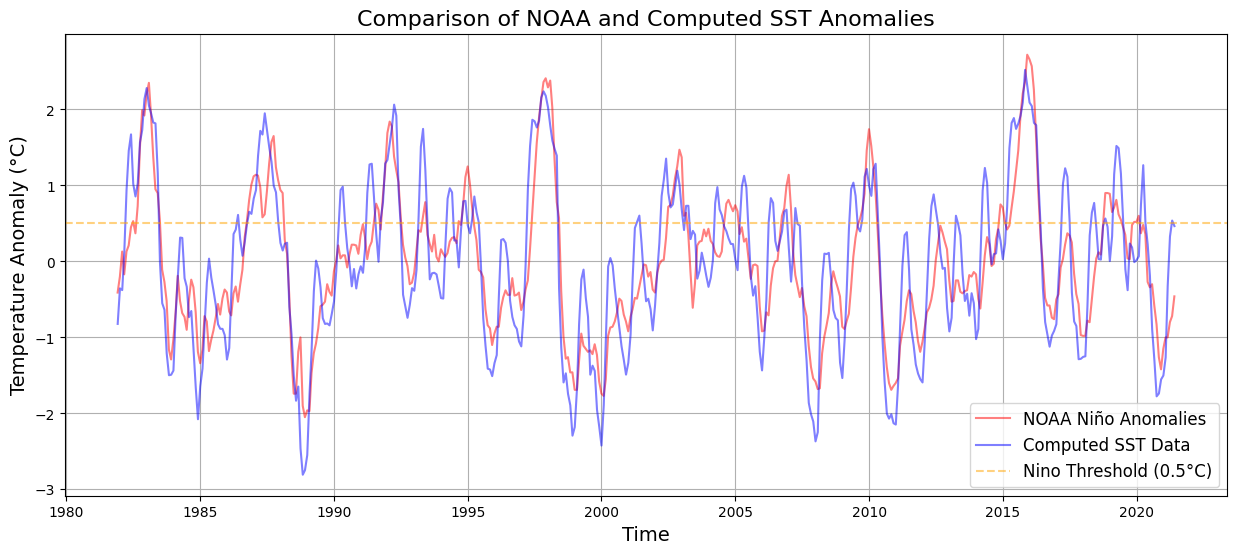

In [12]:
#Visualize the SST and Noa Data
plt.figure(figsize =[15, 6])

# Plot the NOAA data
plt.plot(
    noaa_series_common["time"],  
    noaa_series_common["anomaly_noaa"],  
    label = "NOAA Niño Anomalies", 
    color = "red",  
    linestyle = "-", 
    alpha = 0.5 
)

# Plot the SST data
plt.plot(
    nino_sst_anomaly_df["time"],  
    nino_sst_anomaly_df["anomaly_calculated"],  
    label="Computed SST Data", 
    color = "blue", 
    linestyle = "-", 
    alpha = 0.5 
)


plt.axhline(0.5, color = "orange", linestyle = "--", label = "Nino Threshold (0.5°C)", alpha = 0.5 )  
plt.title("Comparison of NOAA and Computed SST Anomalies", fontsize = 16)
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Temperature Anomaly (°C)", fontsize = 14)
plt.legend(fontsize = 12)
plt.grid(True)

# Save the graph
plt.savefig("images/comparison_noaa_sst.png")
plt.show()

## I) 2) Removing the Seasonal Cycle 

One idea is to remove the seasonal cycle to see if we can predict El Nino events better 

C:\Users\Audrey Airaud\AppData\Local\Temp\ipykernel_1972\1109081121.py:23: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


<Figure size 640x480 with 0 Axes>

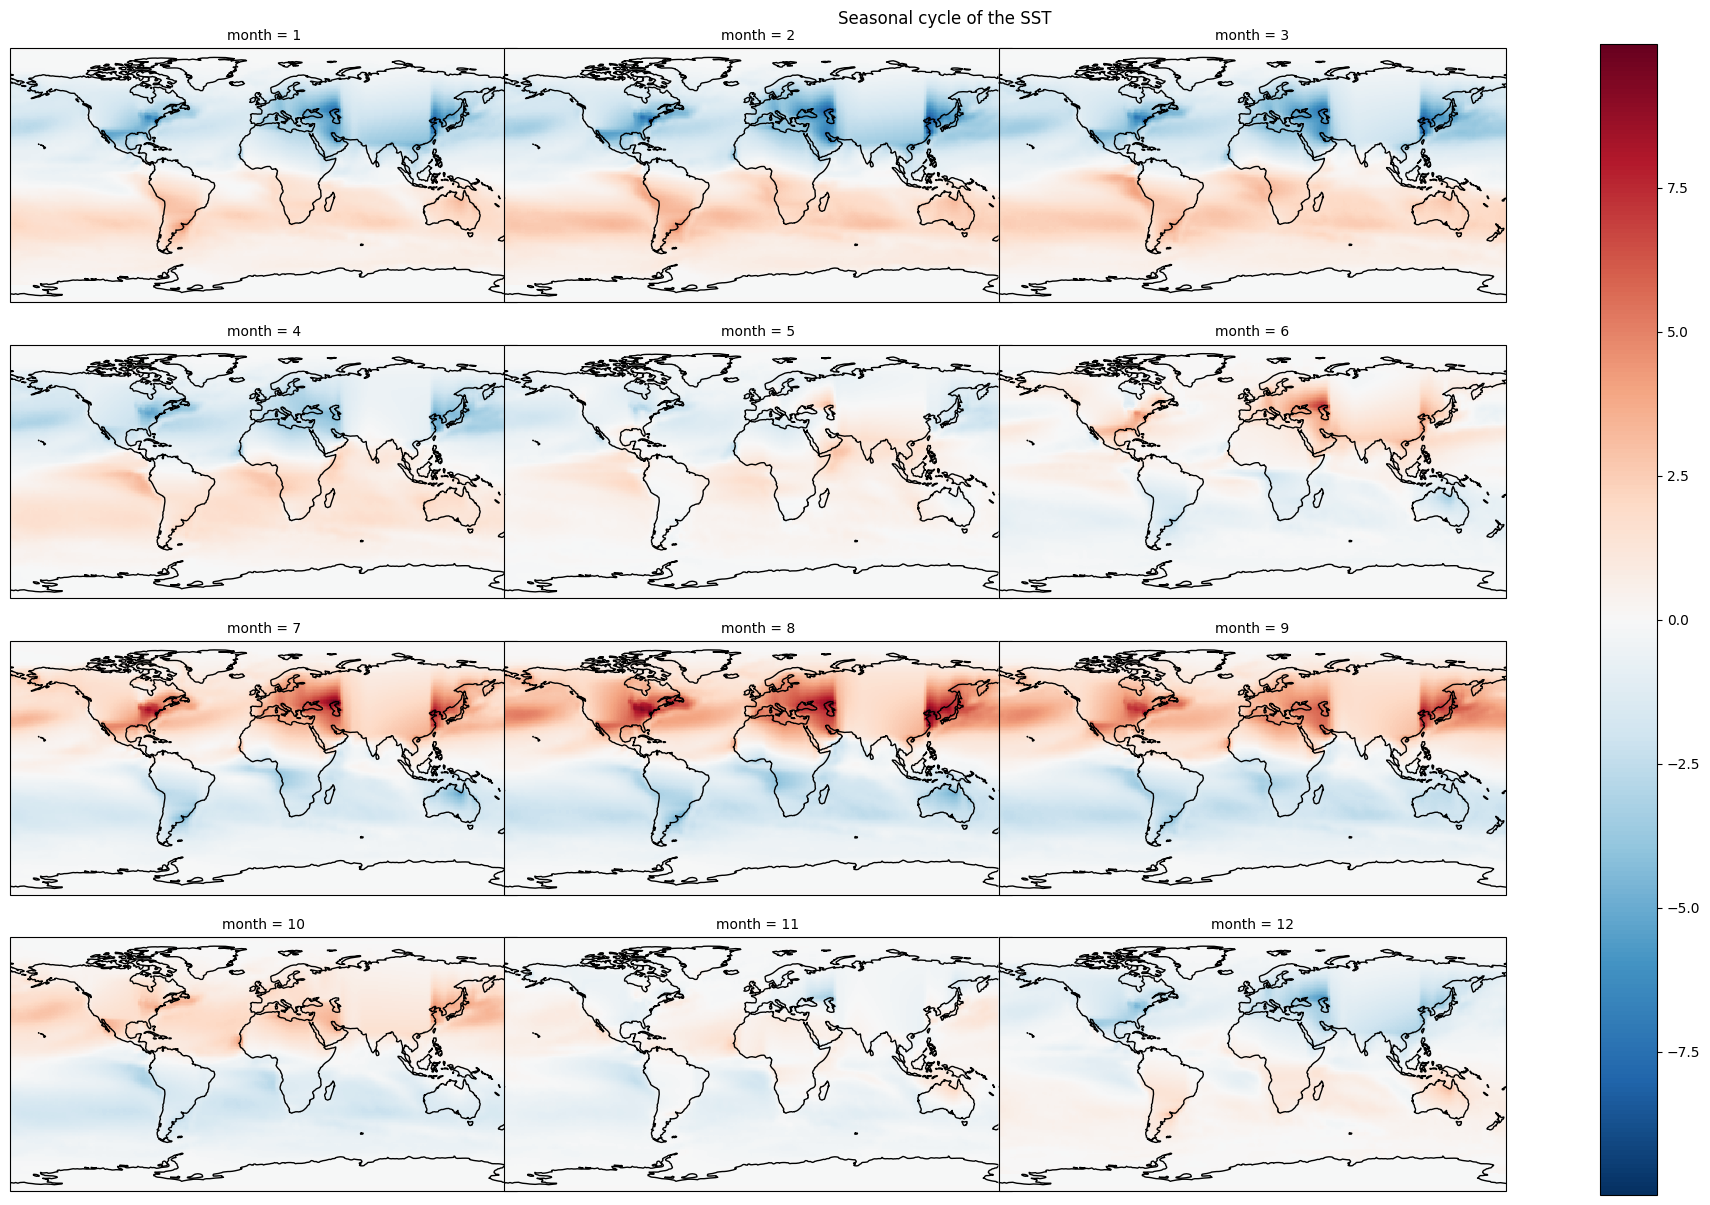

In [13]:
sst = sst_ds.sst
# Compute the mean
sst_mean = sst.mean('time') 
# Compute deviations from the mean
sst_dev = sst - sst_mean
# Get grid-point area coefficients
coef = np.cos(np.deg2rad(sst['lat']))
# Scale height by coefficient
sst_scaled = sst_dev * coef

# Compute monthly seasonal cycle
gps = sst_scaled.groupby('time.month')
# Get seasonal cycle
sst_seasonal = gps.mean()

# Get seasonal anomalies
sst_anom_seasonal = sst_scaled.groupby('time.month') - sst_seasonal

# Plot each month of seasonal cycle
fig = plt.figure()
col_wrap = 3
g = sst_seasonal.plot(x='lon', y='lat', col='month', col_wrap=col_wrap, subplot_kws=dict(projection=ccrs.PlateCarree()),aspect=2)
for ax in g.axes.flat:
    ax.coastlines()
_ = plt.suptitle('Seasonal cycle of the SST', y=1)
plt.savefig("images/seasonal_cycle.png")


Now let's do the same thing as in the previous part: we already have y, let's create X

In [14]:
# Let's create our dataset for the prediction 1 month in advance
# We have to suppress the First and the Last month of the original dataset
all_months = pd.to_datetime(nino_sst_anomaly.time.values)

# We keep the same y_1m as before
y_1m_seasonal = y_1m

# Let's create X: extract the SST data for all valid months
sst_global_data_seasonal = sst_anom_seasonal.sel(time = slice(all_months[0], all_months[-2]))
X_1m_seasonal = sst_global_data_seasonal.values.reshape(len(all_months) - 1, -1)  #Flatten the data by month 

# Verify that the size are correct 
print(X_1m_seasonal.shape, y_1m_seasonal.shape)

#Save the data under the format .npz (optional)
# np.savez_compressed("data/preprocessed_data/nino_dataset_1m_seasonal.npz", X=X_1m_seasonal, y=y_1m_seasonal)

(474, 64800) (474,)


# II) Prediction of El Nino events 
## 1) One-month prediction of El Niño Event

In [15]:
# Get the data for a 1-month prediction
X, y = datasets[1]["X"], datasets[1]["y"]

# Get the data without the seasonal cycle for 1-month prediction
X_wo_sc, y_wo_sc = X_1m_seasonal, y_1m_seasonal

### A. Baseline - LDA

In this part, we explore a simple model, to have a first prediction score and then decide guideines for the rest of our work. We also want to compare prediction with and without the seasonal cycle.

#### A.1 First evaluation

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


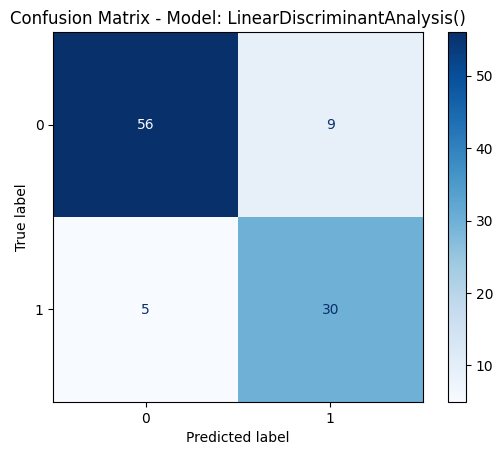

In [16]:
# Evaluation with data with the seasonal cycle 

# Split the data for a first evaluation
X_train, X_test, y_train, y_test= split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_lda, roc_auc_score_test_lda = test_model(lda, X_train,
                                                    X_test, y_train, y_test)

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.976
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.610
     AUC for TEST data: 0.628


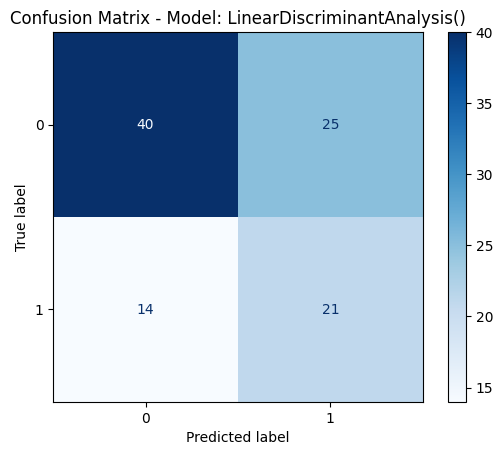

In [17]:
# Evaluation with data without the seasonal cycle 

# Split the data for a first evaluation
X_train_wo_sc, X_test_wo_sc, y_train_wo_sc, y_test_wo_sc = split_scale_data(X_wo_sc, y_wo_sc, RANDOM_SPLIT = False, train_size = 374)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_lda_wo_sc, roc_auc_score_test_lda_wo_sc = test_model(lda, X_train_wo_sc,
                                                                              X_test_wo_sc, y_train_wo_sc, y_test_wo_sc)

In [18]:
# Find which data predicts the best: 
if(accuracy_score_test_lda_wo_sc > accuracy_score_test_lda): 
    print("Data without the seasonal cycle is the best for prediction")
    print(f"Difference of score{accuracy_score_test_lda_wo_sc - accuracy_score_test_lda}")
else: 
    print("Data with the seasonal cycle is the best for prediction")
    print(f"Difference of score: {accuracy_score_test_lda - accuracy_score_test_lda_wo_sc}")

Data with the seasonal cycle is the best for prediction
Difference of score: 0.25


What we can conclude from this part: 

1) Seasonality is useful to predict El Nino Events. This is not surprising because El Niño events tend to begin during the spring or summer of the Northern Hemisphere (March to May) and they generally reach their peak intensity between November and February (Northern Hemisphere winter). This is when SST anomaly in the central and eastern equatorial Pacific is at its highest.
We are going to use data with season information in the next part of the notebook.

2) We can see here that the model is overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

#### A.2. Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

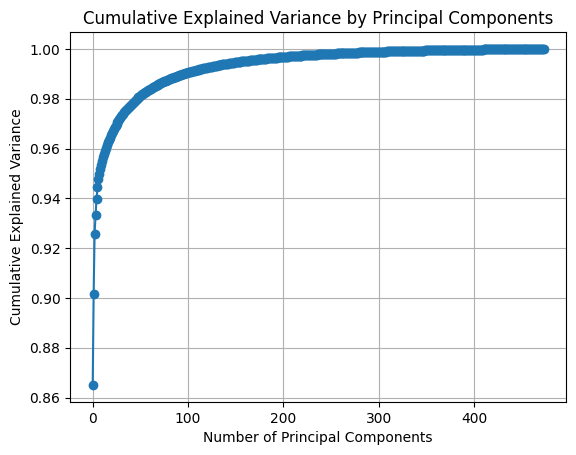

In [19]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

What we are going to do now is to perform a cross validation on the dimension of the PCA. First, we are going to define a train and a validation set. Then, we are going to go through all the dimensions between 1 and 100 to see on which dimension the model performs the best. 

In [20]:
# We work with the original data and split it 
X_train, X_test, y_train, y_test = split_scale_data(
    X, y, RANDOM_SPLIT=False, train_size=374
    )

X_train_cv, X_validation, y_train_cv, y_validation = split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300, scale= False
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (74, 64800)
Shape of y_test: (74,)


Best value of p - PCA : 16
Train Score for the best p: 0.9233333333333333
Test Score for the best p: 0.9324324324324325


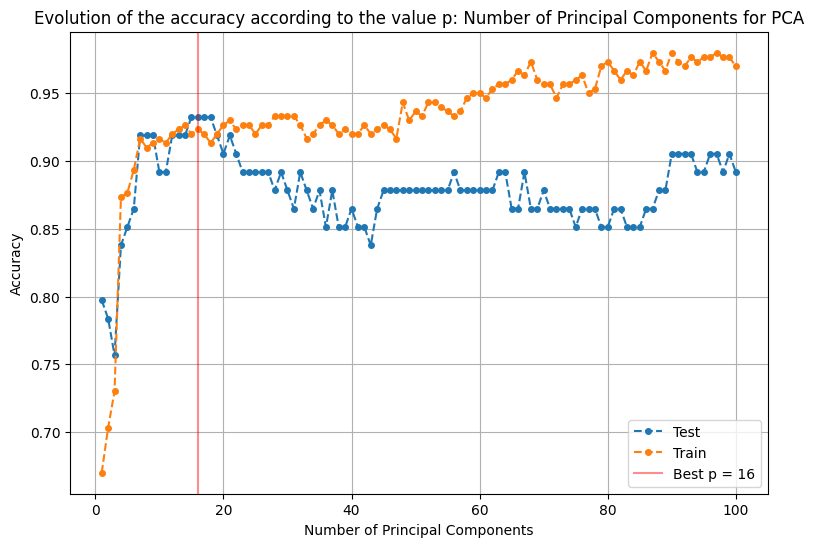

In [21]:
best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, LinearDiscriminantAnalysis(),
                                    dim_max=100, verbose = True)

Once we know the best parameter, we evaluate our model on the test set: 

==== TRAIN ====
Accuracy for TRAIN data: 0.917
     AUC for TRAIN data: 0.968
==== TEST ====
Accuracy for TEST data: 0.870
     AUC for TEST data: 0.946


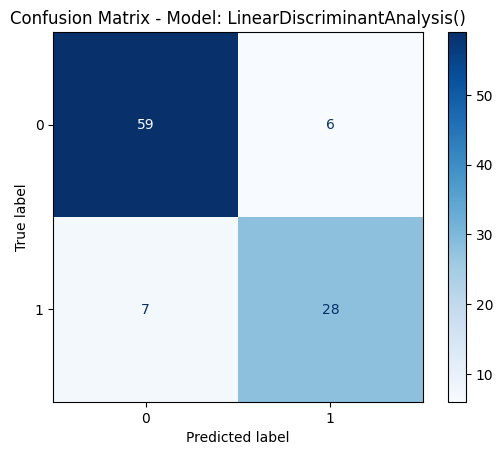

In [22]:
# PCA with the best p parameter
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_LDA, roc_auc_score_test_LDA = test_model(lda, X_train_projected,
                                                            X_test_projected,
                                                            y_train, y_test)

### B. Ridge and Lasso for classification task

In this part, we explore the use of Ridge and Lasso Regressions for the classification task, as we want to perform regularization to prevent overfitting.

#### B.1 Ridge Classification 

c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.73634e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


==== TRAIN ====
Accuracy for TRAIN data: 1.000
     AUC for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.850
     AUC for TEST data: 0.916


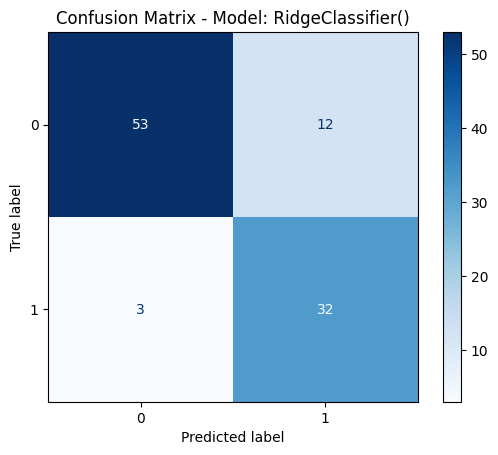

In [23]:
# Define and evaluate the Ridge classifier on the original training and test data
ridge = RidgeClassifier(alpha = 1.0)  # Default hyperparameter

# Test the model
accuracy_score_test_ridge, roc_auc_score_test_ridge = test_model(ridge, X_train, X_test, y_train, y_test)

In [24]:
best_lambda, max_accuracy_validation_Ridge, train_accuracy_Ridge, lambda_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=1,
                                                                                           high_power=7,
                                                                                           nb_points=100)


Best parameter value after validation: 12328.5
Accuracy for training: 0.987
Accuracy for validation: 0.905


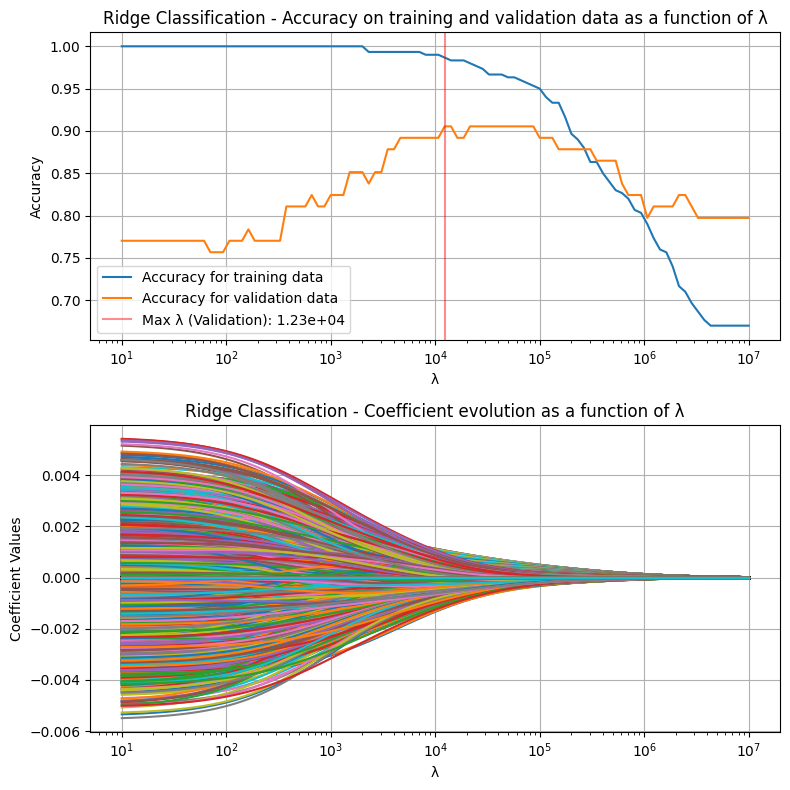

In [25]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [8, 8])

# Plot accuracy for training and validation sets
plt.subplot(2, 1, 1)
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {best_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()

# Plot coefficient evolution
plt.subplot(2, 1, 2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge Classification - Coefficient evolution as a function of λ')

plt.tight_layout()
plt.show()

==== TRAIN ====
Accuracy for TRAIN data: 0.979
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.910
     AUC for TEST data: 0.959


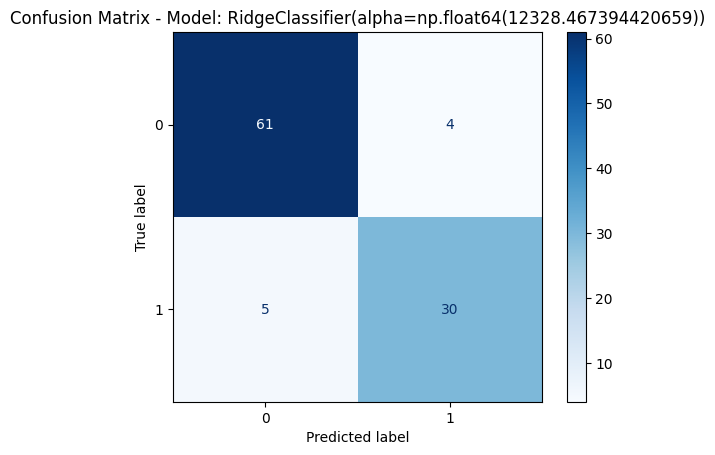

In [26]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = best_lambda)

# Test the model
accuracy_score_test_RIDGE, roc_auc_score_test_RIDGE = test_model(ridge, X_train,X_test,
                                                                y_train, y_test)

#### B.2 Lasso Classification

In this part, we will use the Lasso algorithm to perform a regularization of our model, trying to prevent overfitting. As there is no "LassoClassifier" function, we will use the LogisticRegression function with penalty parameter set to "l1".

==== TRAIN ====
Accuracy for TRAIN data: 1.000
     AUC for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.880
     AUC for TEST data: 0.959


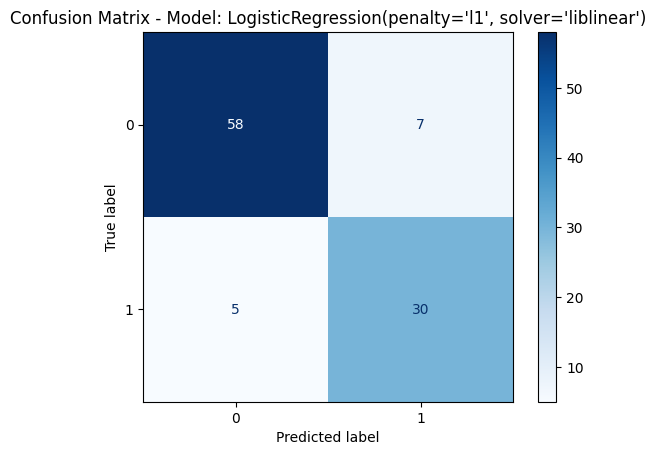

In [27]:
# Define the classifier
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0) 

# Test the model
accuracy_score_test_lasso, roc_auc_score_test_lasso = test_model(lasso, X_train,
                                                                X_test, y_train, y_test)

In [28]:
best_C, max_accuracy_validation_Lasso, train_accuracy_Lasso, C_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=-3,
                                                                                           high_power=2,
                                                                                           nb_points=50,
                                                                                           Ridge=False)


Best parameter value after validation: 0.2
Accuracy for training: 0.957
Accuracy for validation: 0.946


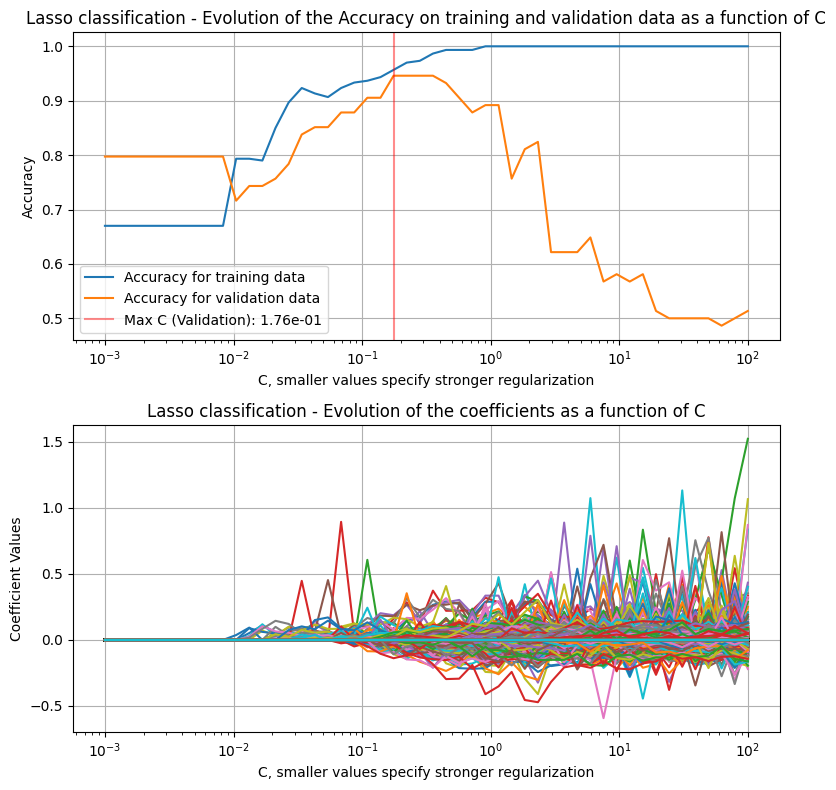

In [29]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_C, color = 'r', linestyle = '-', label = f'Max C (Validation): {best_C:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

==== TRAIN ====
Accuracy for TRAIN data: 0.955
     AUC for TRAIN data: 0.992
==== TEST ====
Accuracy for TEST data: 0.900
     AUC for TEST data: 0.972


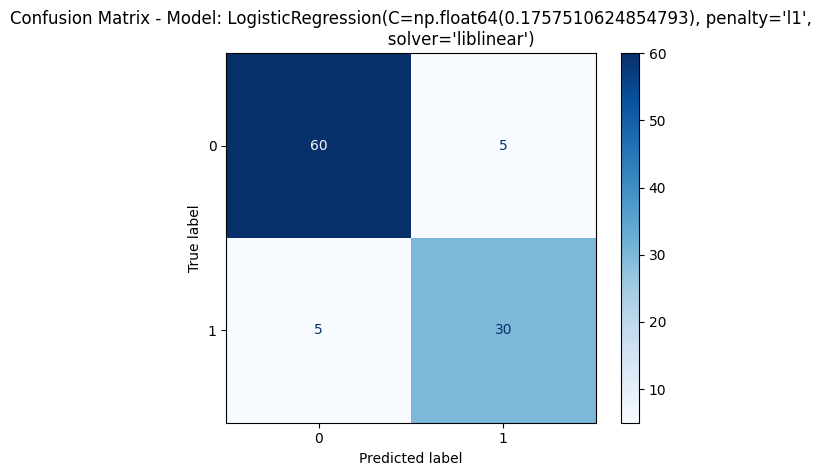

In [30]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = best_C)

# Test the model
accuracy_score_test_LASSO, roc_auc_score_test_LASSO = test_model(lasso, X_train,X_test,
                                                                y_train, y_test)

### C. Test Different Models

In this part, we want to do hyper-parameter tuning for different chosen models. However we have a lot of features and probably some of them are correlated which can prevent the models from performing properly. Here we perform a PCA, keeping 50 features, as the cumulative explained variance for 50 features is around 98% (see graph of the begining of the notebook). With this dimensionality reduction, we test the models to see which one is the better and then we select the best one and perform PCA more precisely on the data, to see with which dimensions it performs the best.

In [31]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X_train)

# Project data
Xp_train = PCA_sst.transform(X_train)
Xp_test = PCA_sst.transform(X_test)

In [32]:
# Hyperparameter tuning pipeline
# param grid for hyper-parameter tuning
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [qda_params, rf_params, svc_params, gb_params]

models = [QuadraticDiscriminantAnalysis(), RandomForestClassifier(), SVC(probability=True), GradientBoostingClassifier()]
model_names = ["QDA", "RandomForestClassifier", "SVC", "GradientBoostingClassifier"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(Xp_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(Xp_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(Xp_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc

print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")


Tuning QDA
Best Parameters for QDA: {'reg_param': 0.9}
Test Accuracy: 0.6700, Test AUC: 0.8462

Tuning RandomForestClassifier
Best Parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 50}
Test Accuracy: 0.7700, Test AUC: 0.8725

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8800, Test AUC: 0.9679

Tuning GradientBoostingClassifier
Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Test Accuracy: 0.8200, Test AUC: 0.8897

Best Model: SVC
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Accuracy: 0.8800
Best AUC: 0.9679


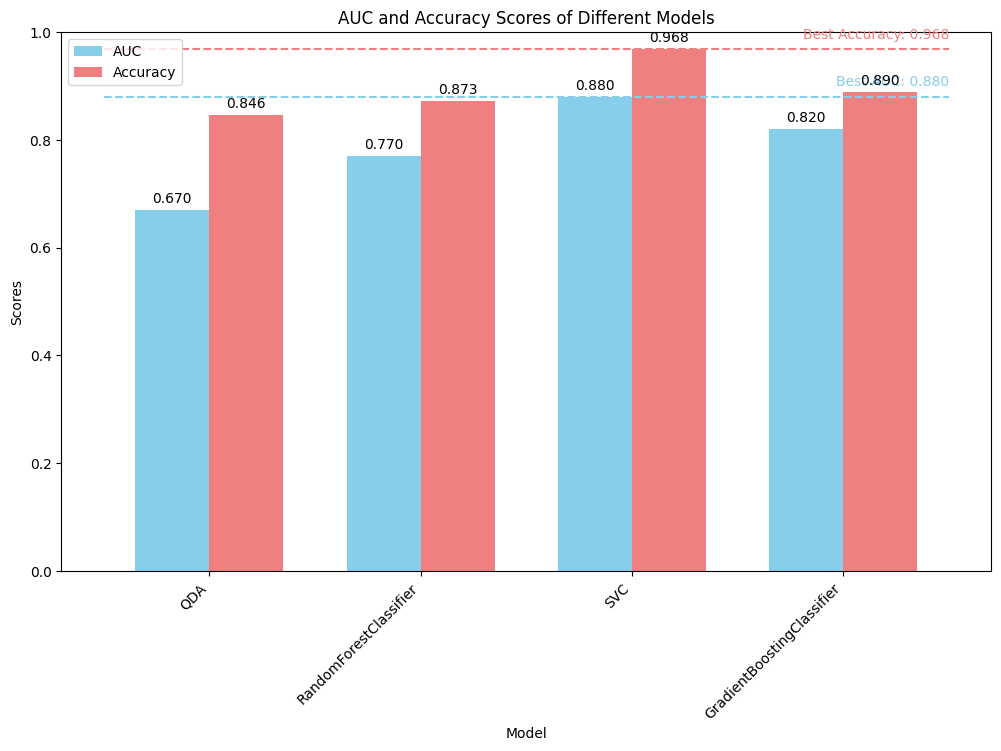

In [33]:
#Plot the scores from the different models to be able to compare the scores visualy
plot_score(model_names, models_accuracies, models_auc)

We proceed exactly as we did with LDA: we perform cross validation on the parameter p of the PCA to see on which dimensions the model performs the best.

Best value of p - PCA : 11
Train Score for the best p: 0.9533333333333334
Test Score for the best p: 0.918918918918919


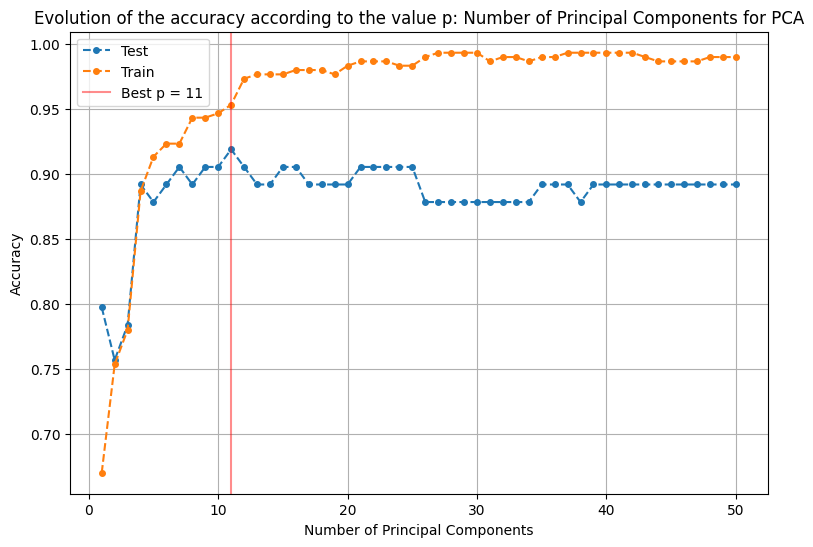

In [34]:
best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, best_model,
                                    dim_max=50, verbose = True)

Finally, we evaluate our model with the best parameter p on the test set 

==== TRAIN ====
Accuracy for TRAIN data: 0.952
     AUC for TRAIN data: 0.987
==== TEST ====
Accuracy for TEST data: 0.900
     AUC for TEST data: 0.979


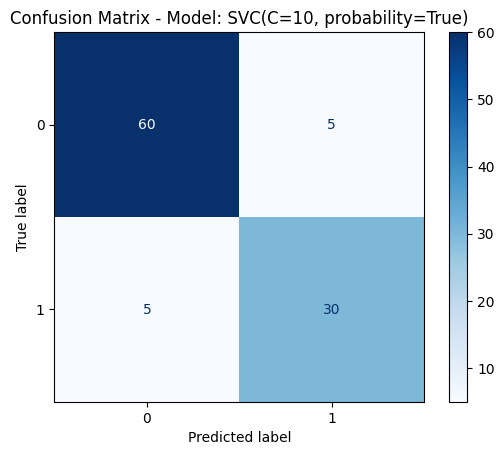

In [35]:
# PCA with the best parameter p 
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_SVC, roc_auc_score_test_SVC = test_model(best_model, X_train_projected,
                                                            X_test_projected,
                                                            y_train, y_test)

### D. Neural Networks 

Let's try to use Neural Networks for now. We are going to project the data on 50 features and do our hyper-parameter tuning (just like in part C) and then we will select the best model and look for the best p dimensions of PCA.

In [36]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(Xp_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.898


Best value of p - PCA : 11
Train Score for the best p: 0.9266666666666666
Test Score for the best p: 0.918918918918919


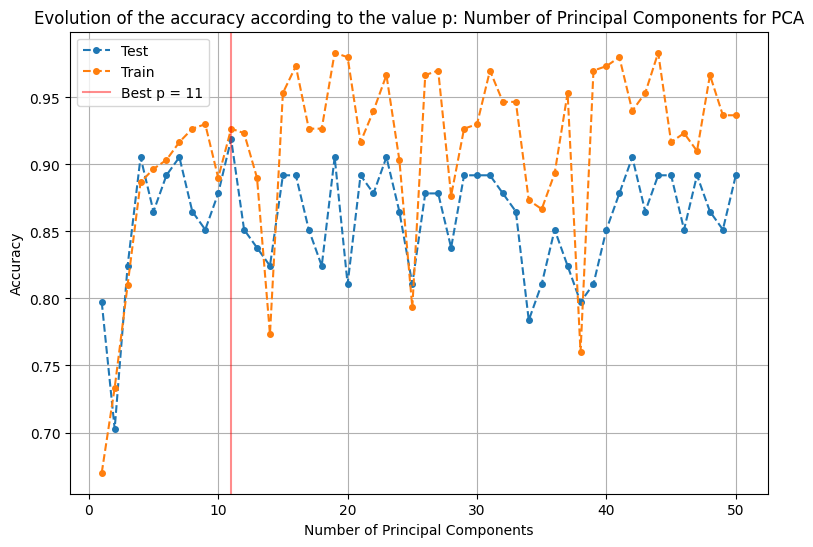

In [37]:
best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, grid_search.best_estimator_,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.896
     AUC for TRAIN data: 0.929
==== TEST ====
Accuracy for TEST data: 0.840
     AUC for TEST data: 0.927


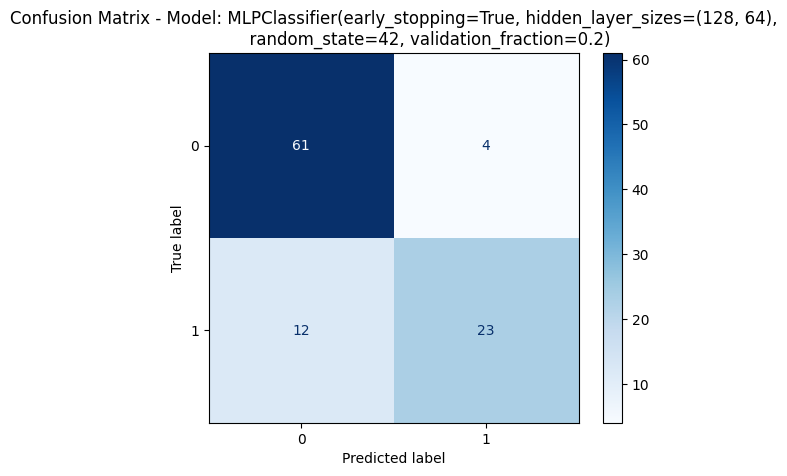

In [38]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_MLP, roc_auc_score_test_MLP = test_model(grid_search.best_estimator_,
                                                            X_train_projected,
                                                            X_test_projected,
                                                            y_train, y_test)

### E. Recap of the Models

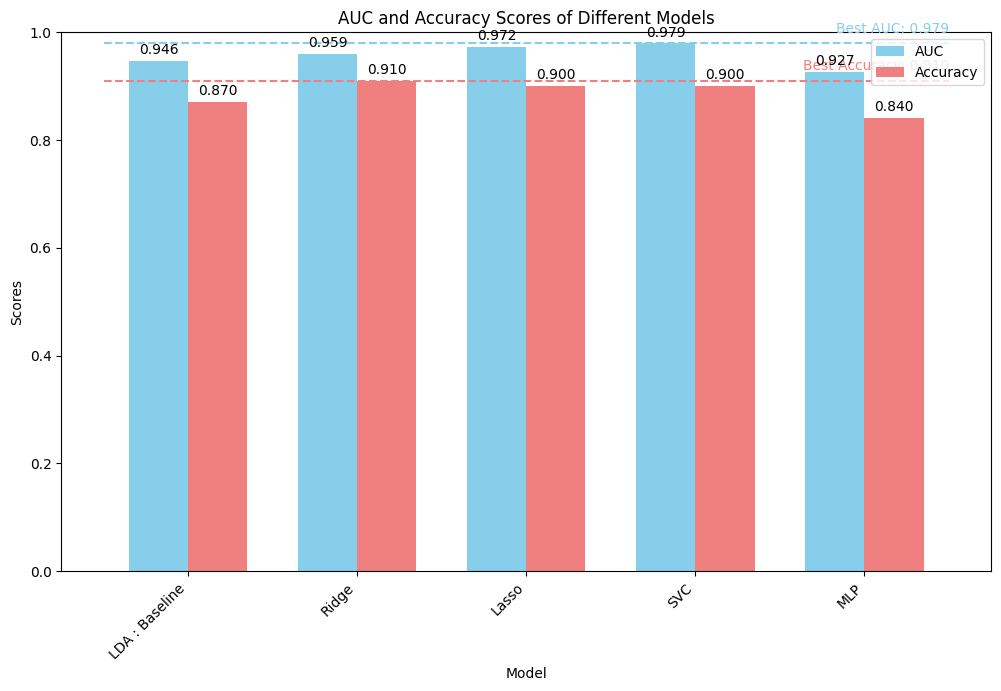

In [39]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [accuracy_score_test_LDA, accuracy_score_test_RIDGE, accuracy_score_test_LASSO, accuracy_score_test_SVC, accuracy_score_test_MLP]
models_auc = [roc_auc_score_test_LDA, roc_auc_score_test_RIDGE, roc_auc_score_test_LASSO, roc_auc_score_test_SVC, roc_auc_score_test_MLP]
plot_score(model_names, models_auc, models_accuracies)

For a 1-month prediction, the model that has the best accuracy is the Ridge Modeland the one that has the best AUC is the SVC model.

## 2) Two-month prediction of El Niño Events

In this part, we will apply the 5 five models tested before and see if the results change as the prediction is for 2 months.

In [40]:
# Get the data for a 2-month prediction
X2, y2 = datasets[2]["X"], datasets[2]["y"]

### A. LDA

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (373, 64800)
Shape of y_train: (373,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.989
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.770
     AUC for TEST data: 0.870


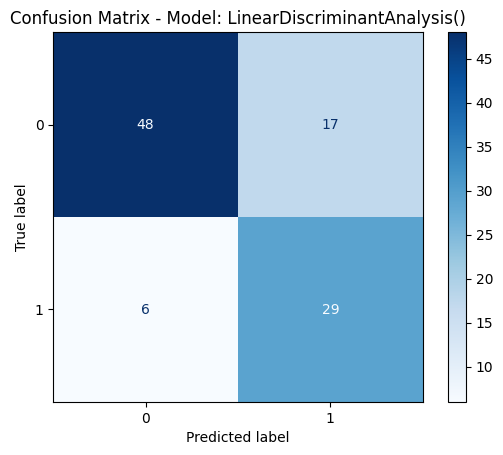

In [41]:
# Split the data for a first evaluation
X_train, X_test, y_train, y_test= split_scale_data(X2, y2, RANDOM_SPLIT = False, train_size = 373)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_lda, roc_auc_score_test_lda = test_model(lda, X_train,
                                                            X_test, y_train, y_test)

The score is lower than with the first model for 1-month prediction. We face overfitting. Let us see if we can obtain better results with PCA.

In [42]:
# We work with the original data and split it 
X_train, X_test, y_train, y_test = split_scale_data(
    X2, y2, RANDOM_SPLIT=False, train_size=373
    )

X_train_cv, X_validation, y_train_cv, y_validation = split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300, scale= False
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (373, 64800)
Shape of y_train: (373,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (73, 64800)
Shape of y_test: (73,)


Best value of p - PCA : 13
Train Score for the best p: 0.9
Test Score for the best p: 0.9178082191780822


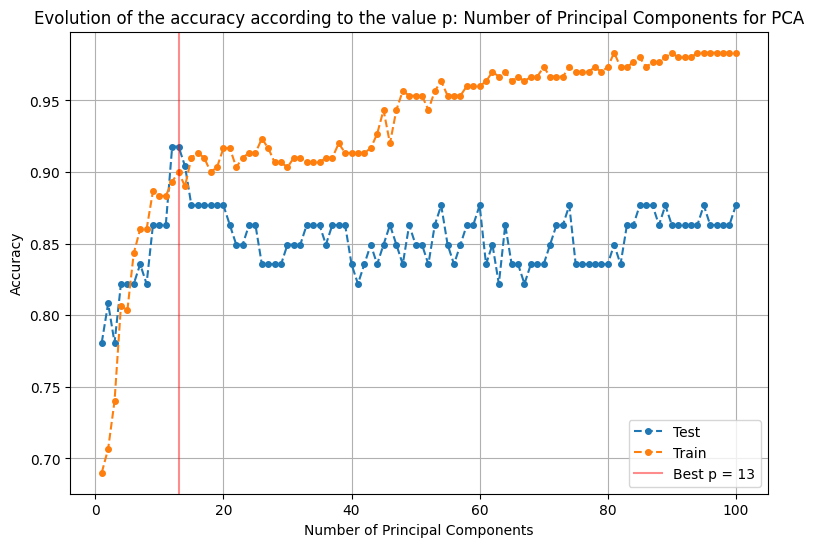

In [43]:
best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, LinearDiscriminantAnalysis(),
                                    dim_max=100, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.879
     AUC for TRAIN data: 0.945
==== TEST ====
Accuracy for TEST data: 0.900
     AUC for TEST data: 0.948


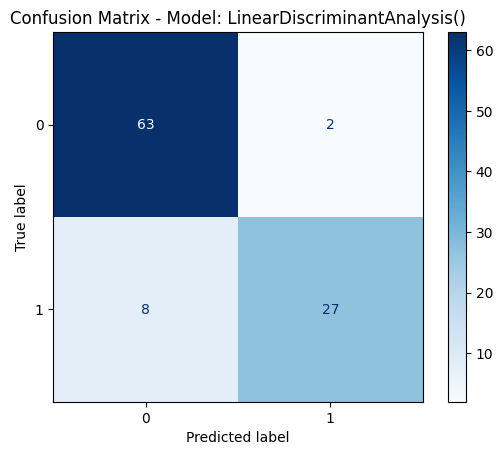

In [44]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_LDA_2, roc_auc_score_test_LDA_2 = test_model(lda, X_train_projected,
                                                                X_test_projected,
                                                                y_train, y_test)

### B. Ridge and Lasso for classification

#### B.1 Ridge Classification

In [45]:
best_lambda, max_accuracy_validation_Ridge, train_accuracy_Ridge, lambda_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=1,
                                                                                           high_power=7,
                                                                                           nb_points=100)


Best parameter value after validation: 2656.1
Accuracy for training: 1.000
Accuracy for validation: 0.877


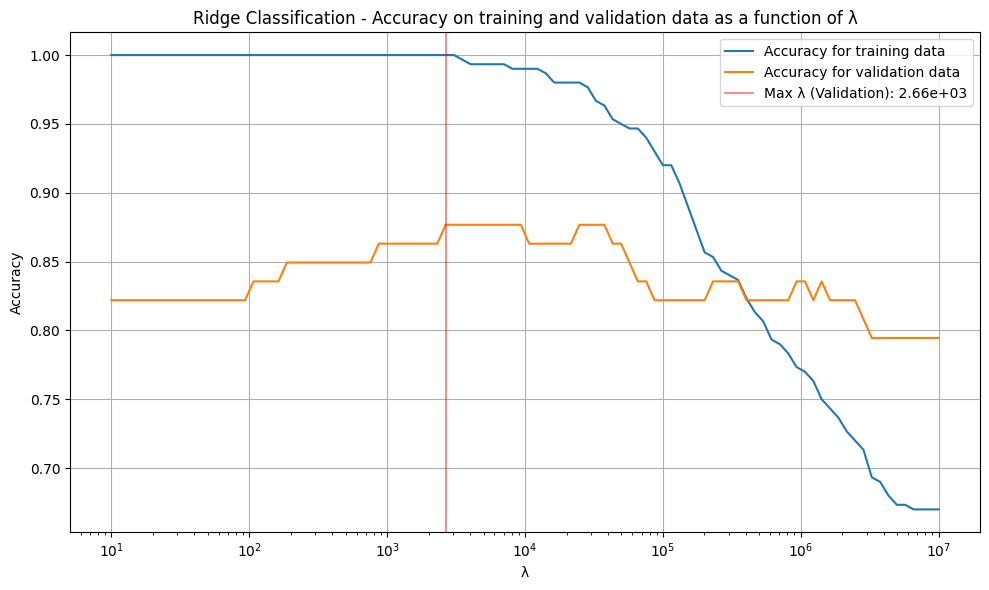

In [46]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [10, 6]) 

# Plot accuracy for training and validation sets
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {best_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()
plt.tight_layout()
plt.show()

==== TRAIN ====
Accuracy for TRAIN data: 1.000
     AUC for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.840
     AUC for TEST data: 0.920


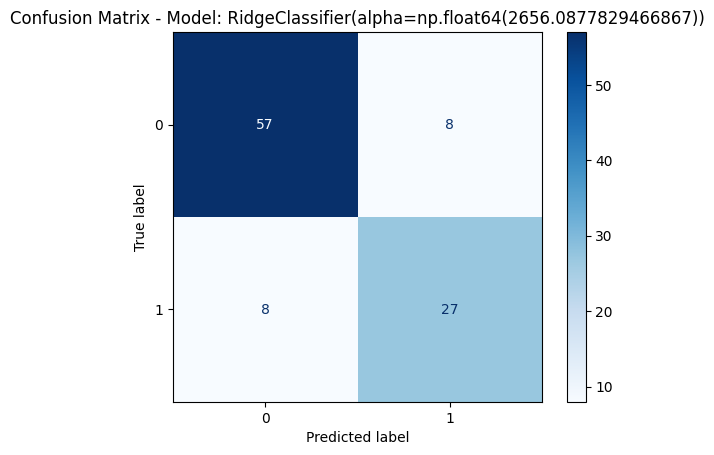

In [47]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = best_lambda)

# Test the model
accuracy_score_test_RIDGE_2, roc_auc_score_test_RIDGE_2 = test_model(ridge, X_train,X_test,
                                                                    y_train, y_test)

#### B.2 Lasso Classification

In [48]:
best_C, max_accuracy_validation_Lasso, train_accuracy_Lasso, C_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=-3,
                                                                                           high_power=2,
                                                                                           nb_points=50,
                                                                                           Ridge=False)


Best parameter value after validation: 0.1
Accuracy for training: 0.943
Accuracy for validation: 0.863


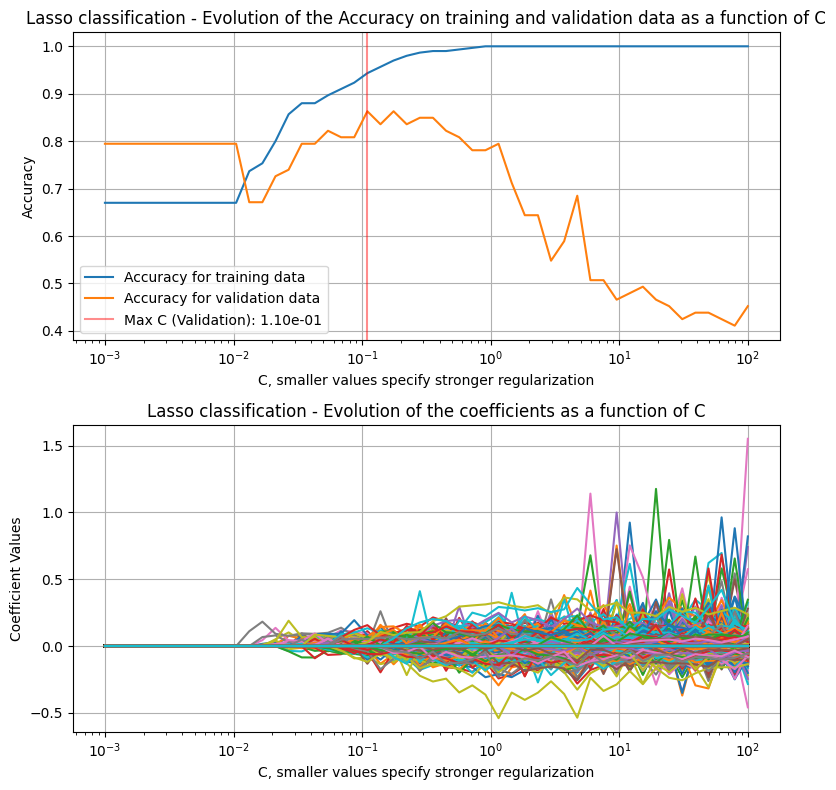

In [49]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_C, color = 'r', linestyle = '-', label = f'Max C (Validation): {best_C:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

==== TRAIN ====
Accuracy for TRAIN data: 0.938
     AUC for TRAIN data: 0.984
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.926


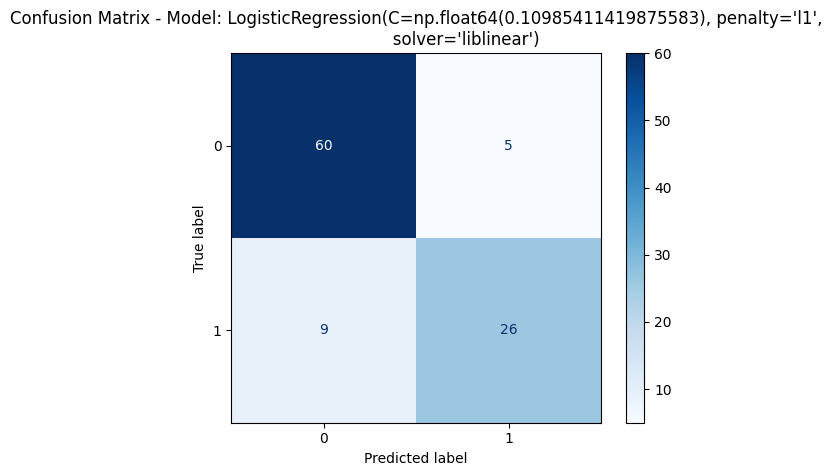

In [50]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = best_C)

# Test the model
accuracy_score_test_LASSO_2, roc_auc_score_test_LASSO_2 = test_model(lasso, X_train,X_test,
                                                                    y_train, y_test)

### C. SVC

In [51]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X_train)

# Project data
Xp_train = PCA_sst.transform(X_train)
Xp_test = PCA_sst.transform(X_test)

In [52]:
# param grid for hyper-parameter tuning
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grids = [svc_params]

models = [SVC(probability=True)]
model_names = ["SVC"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(Xp_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(Xp_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(Xp_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc


Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8300, Test AUC: 0.9297


Best value of p - PCA : 15
Train Score for the best p: 0.9566666666666667
Test Score for the best p: 0.8767123287671232


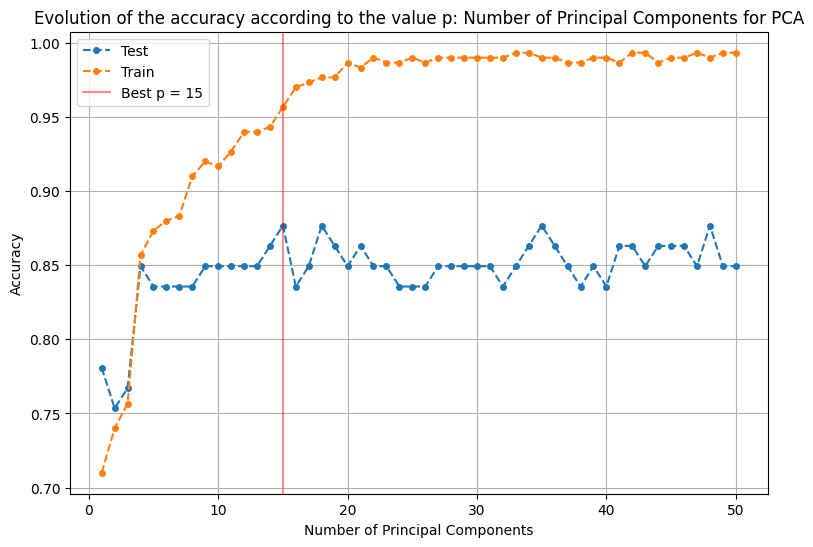

In [53]:
best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, best_model,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.938
     AUC for TRAIN data: 0.985
==== TEST ====
Accuracy for TEST data: 0.880
     AUC for TEST data: 0.950


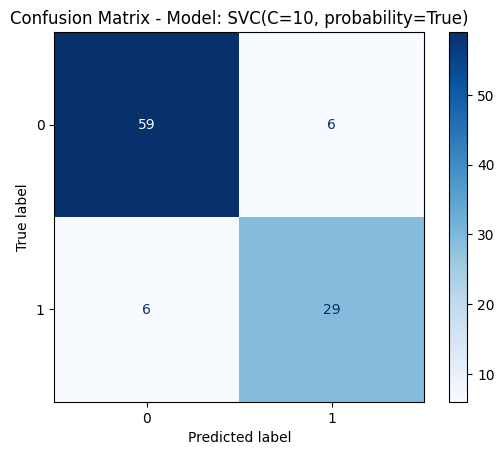

In [54]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_SVC_2, roc_auc_score_test_SVC_2 = test_model(best_model, X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

### C. Neural Networks

In [55]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(Xp_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.01, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.879


Best value of p - PCA : 47
Train Score for the best p: 0.98
Test Score for the best p: 0.9041095890410958


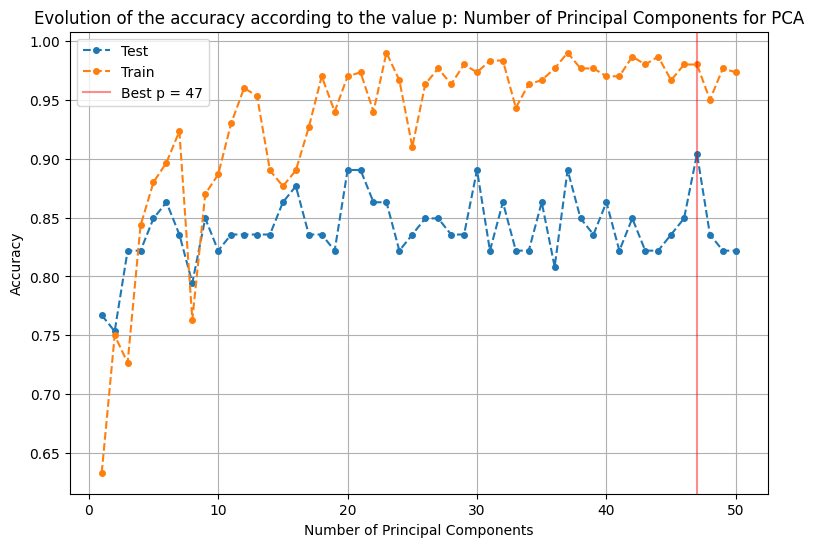

In [56]:
best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, grid_search.best_estimator_,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.957
     AUC for TRAIN data: 0.983
==== TEST ====
Accuracy for TEST data: 0.820
     AUC for TEST data: 0.932


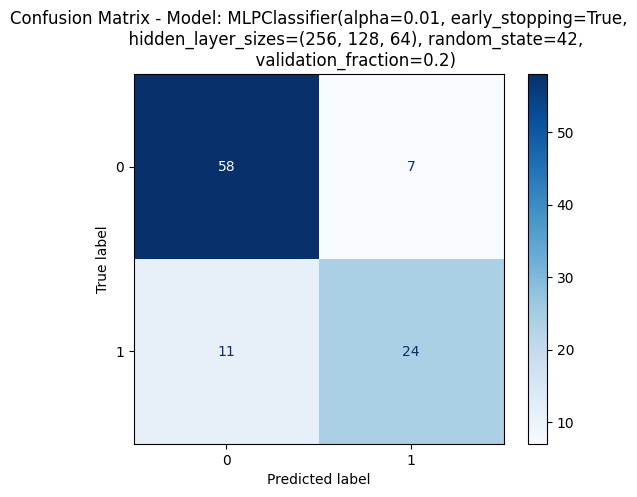

In [57]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_MLP_2, roc_auc_score_test_MLP_2 = test_model(grid_search.best_estimator_,
                                                                X_train_projected,
                                                                X_test_projected,
                                                                y_train, y_test)

### E. Recap of the models

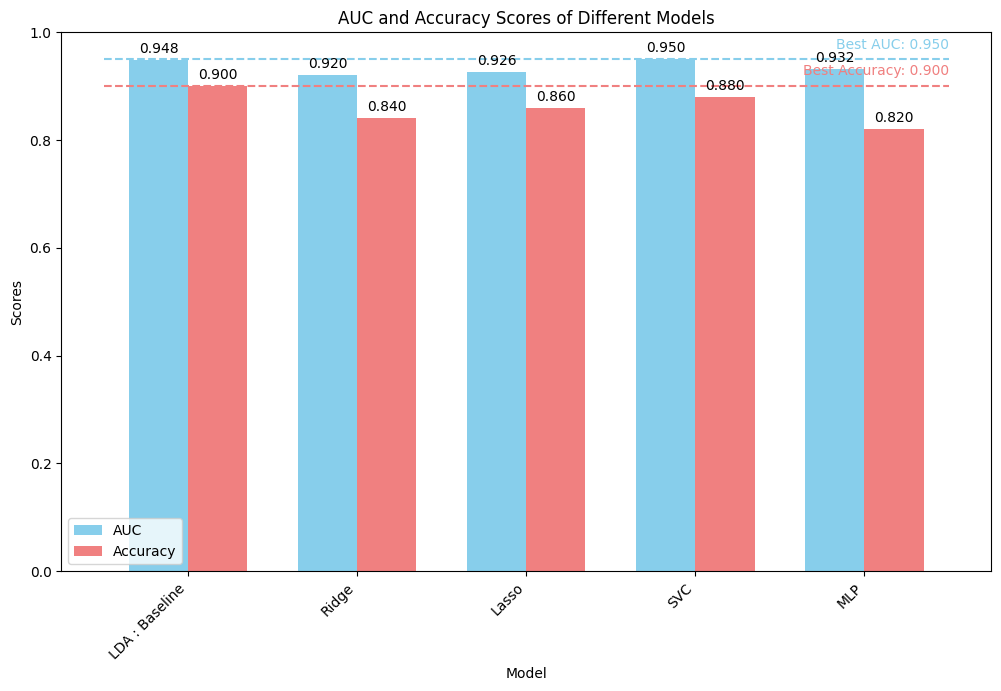

In [58]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [accuracy_score_test_LDA_2, accuracy_score_test_RIDGE_2, accuracy_score_test_LASSO_2, accuracy_score_test_SVC_2, accuracy_score_test_MLP_2]
models_auc = [roc_auc_score_test_LDA_2, roc_auc_score_test_RIDGE_2, roc_auc_score_test_LASSO_2, roc_auc_score_test_SVC_2, roc_auc_score_test_MLP_2]
plot_score(model_names, models_auc, models_accuracies)

Let's compare one and two months prediction scores. 

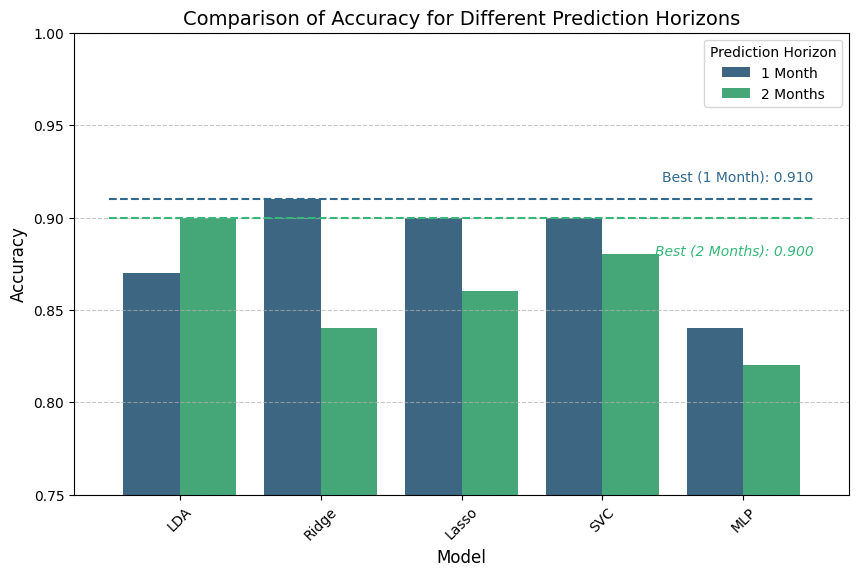

In [59]:
data = {
    'Model': ['LDA', 'Ridge', 'Lasso', 'SVC', 'MLP'],
    'Accuracy_1_month': [accuracy_score_test_LDA, accuracy_score_test_RIDGE, accuracy_score_test_LASSO, accuracy_score_test_SVC, accuracy_score_test_MLP],
    'Accuracy_2_months': [accuracy_score_test_LDA_2, accuracy_score_test_RIDGE_2, accuracy_score_test_LASSO_2, accuracy_score_test_SVC_2, accuracy_score_test_MLP_2]
}

# Créer un DataFrame
accuracy_df = pd.DataFrame(data)

# Reshape the data
accuracy_melted = pd.melt(accuracy_df, id_vars=['Model'], 
                          value_vars=['Accuracy_1_month', 'Accuracy_2_months'],
                          var_name='Prediction_Horizon', value_name='Accuracy')
accuracy_melted['Prediction_Horizon'] = accuracy_melted['Prediction_Horizon'].replace({
    'Accuracy_1_month': '1 Month',
    'Accuracy_2_months': '2 Months'
})

# Find the best scores
best_scores = accuracy_melted.loc[accuracy_melted.groupby('Prediction_Horizon')['Accuracy'].idxmax()]


# Visualization
plt.figure(figsize=(10, 6))

palette = sns.color_palette('viridis', n_colors=len(accuracy_melted['Prediction_Horizon'].unique()))
colors = dict(zip(['1 Month', '2 Months'], palette))

ax = sns.barplot(data=accuracy_melted, x='Model', y='Accuracy', hue='Prediction_Horizon', palette=palette)
plt.title('Comparison of Accuracy for Different Prediction Horizons', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.75, 1.0)
plt.legend(title='Prediction Horizon', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal lines
for _, row in best_scores.iterrows():
    horizon = row['Prediction_Horizon']
    color = colors[horizon] 

    ax.hlines(y=row['Accuracy'], xmin=-0.5, xmax=4.5, colors=color, linestyles='--', linewidth=1.5)

    if horizon == '1 Month': 
        ax.text(4.5, row['Accuracy'] + 0.01, f"Best ({horizon}): {row['Accuracy']:.3f}",
                color=color, ha='right', fontsize=10)
    elif horizon == '2 Months':
        ax.text(4.5, row['Accuracy'] - 0.02, f"Best ({horizon}): {row['Accuracy']:.3f}",
                color=color, ha='right', fontsize=10, style='italic')

plt.show()


## 3) Predictions for more months

In [60]:
# Chose the number of months for the prediction 
n_months = 12

In [61]:
def get_pred_SVC(list_number_months):
    # Initialize output
    list_test_accuracy_SVC = []
    list_test_roc_auc_SVC = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = datasets[N]["X"], datasets[N]["y"]
        # Split the data
        X_train, X_test, y_train, y_test= split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)

        ############################# Tune SVC
        print('######### Tune SVC ...')
        
        # Define PCA for 50 features 
        PCA_sst = PCA(n_components = 50)
        PCA_sst.fit(X_train)

        Xp_train = PCA_sst.transform(X_train)
        Xp_test = PCA_sst.transform(X_test)
        # param grid for hyper-parameter tuning
        svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        param_grids = [svc_params]

        models = [SVC(probability=True)]
        model_names = ["SVC"]

        best_model_name = None
        best_model = None
        best_params = None
        best_accuracy = 0
        best_auc = 0

        models_accuracies = []
        models_auc = []

        for i in range(len(models)):
            print(f"\nTuning {model_names[i]}")
            grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
            grid_search.fit(Xp_train, y_train)

            # Best estimator and parameters
            best_estimator = grid_search.best_estimator_
            best_params_model = grid_search.best_params_
            best_accuracy_model = grid_search.best_score_

            # Evaluate on the test set
            y_test_pred = best_estimator.predict(Xp_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, best_estimator.predict_proba(Xp_test)[:, 1])

            print(f"Best Parameters for {model_names[i]}: {best_params_model}")
            print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

            models_accuracies.append(test_accuracy)
            models_auc.append(test_auc)

            if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
                best_model_name = model_names[i]
                best_model = best_estimator
                best_params = best_params_model
                best_accuracy = test_accuracy
                best_auc = test_auc
        p_values = np.linspace(1, 50, 50).astype(int)
        p_values = p_values.astype(int)
        test_score_accuracy = []
        train_score_accuracy = []
        models_pca = []

        ############################# Tune PCA
        print('######### Tune PCA ...')
        best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, best_model,
                                    dim_max=50, verbose = False)

        ############################# TEST
        print('######### TEST ...')
        # PCA with p principal components
        pca = PCA(n_components = best_p_value)
        pca.fit(X_train)

        # Project data
        X_train_projected = pca.transform(X_train)
        X_test_projected = pca.transform(X_test)

        # Test the model
        accuracy_score_test_SVC, roc_auc_score_test_SVC = test_model(best_model, X_train_projected,
                                                                    X_test_projected,
                                                                    y_train, y_test)
        # Print and get the outputs
        list_test_accuracy_SVC.append(accuracy_score_test_SVC)
        list_test_roc_auc_SVC.append(roc_auc_score_test_SVC)
        
    return list_test_accuracy_SVC, list_test_roc_auc_SVC

#################### 1-months prediction ####################
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.9000, Test AUC: 0.9688
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.968
     AUC for TRAIN data: 0.991
==== TEST ====
Accuracy for TEST data: 0.890
     AUC for TEST data: 0.972
#################### 2-months prediction ####################
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8600, Test AUC: 0.9310
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.938
     AUC for TRAIN data: 0.985
==== TEST ====
Accuracy for TEST data: 0.880
     AUC for TEST data: 0.949
#################### 3-months prediction ####################
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 1, 'kernel': 'rbf'}
Test Accuracy: 0.8500, Test AUC: 0.9336
######### Tune PCA ...
######### TEST ...
==

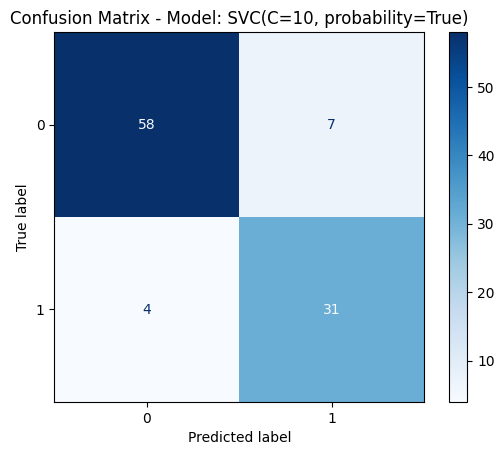

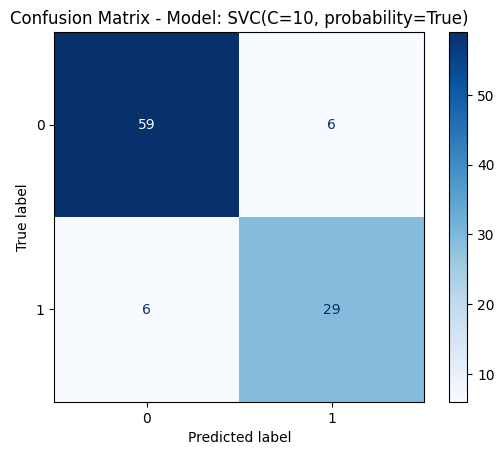

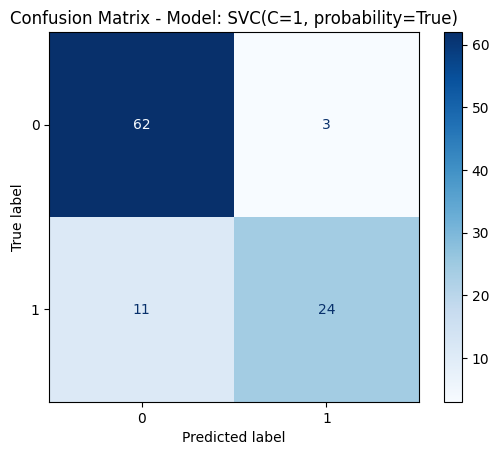

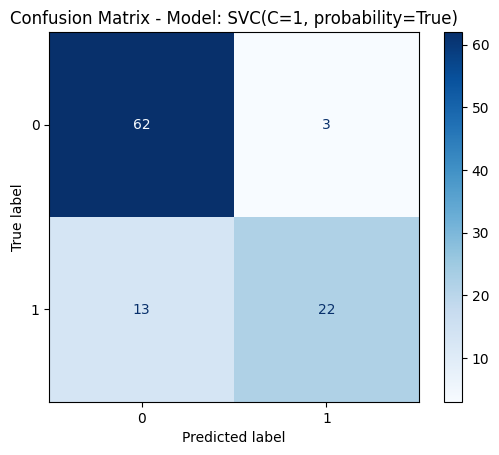

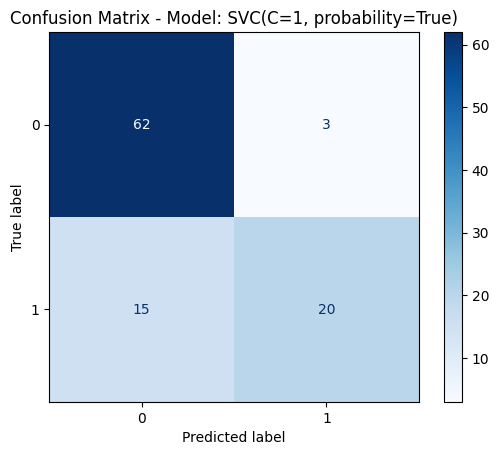

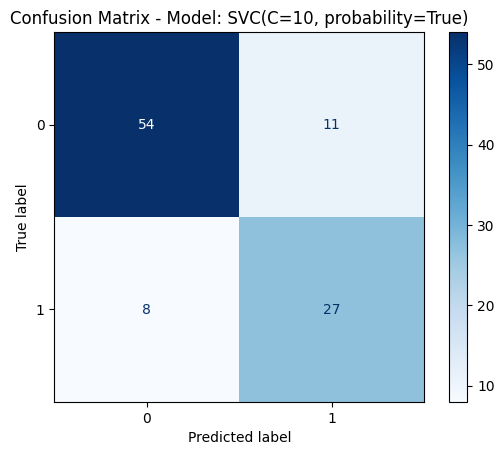

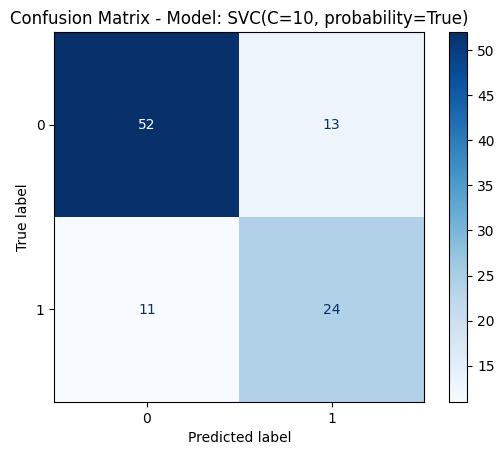

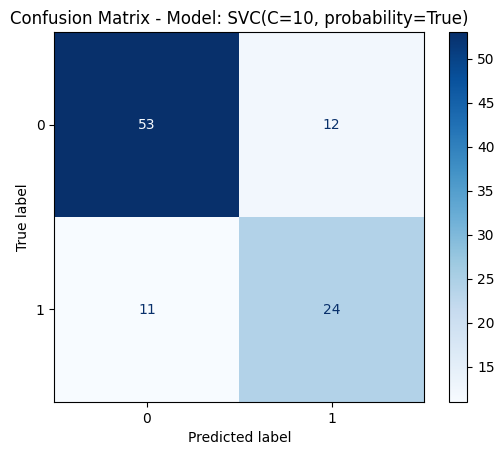

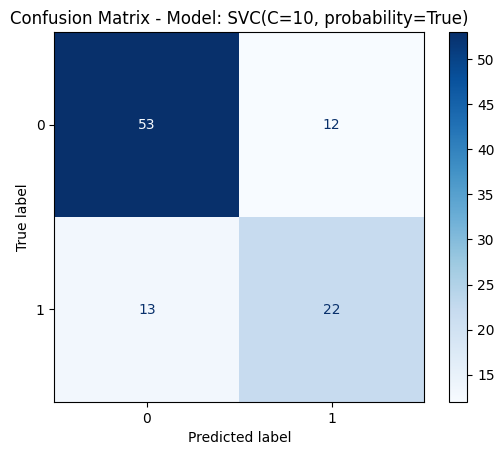

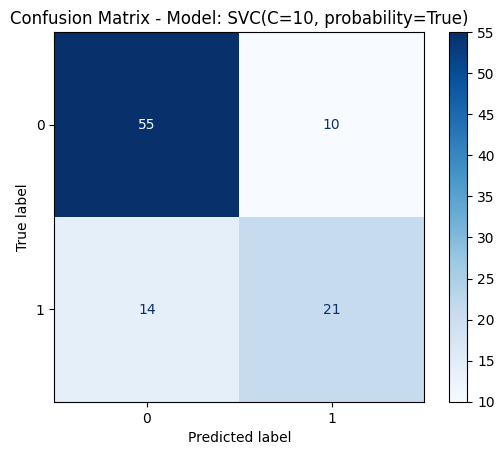

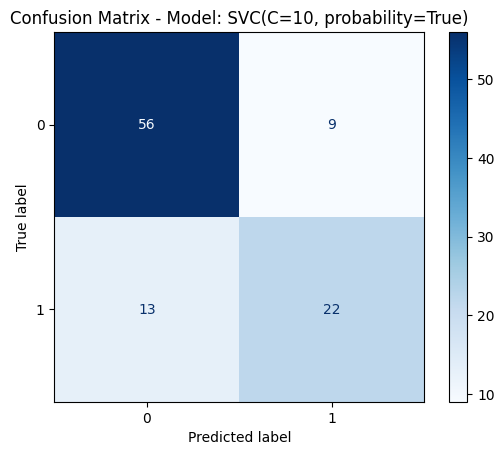

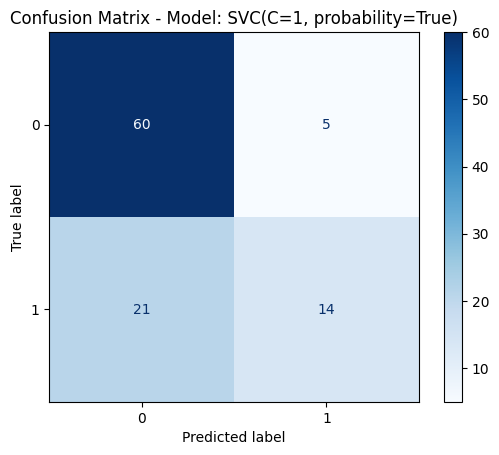

In [62]:
list_test_accuracy_SVC, list_test_roc_auc_SVC = get_pred_SVC(list_number_months=[i for i in range(1,n_months + 1)])

In [63]:
def get_pred_LDA(list_number_months):
    # Initialize output
    list_test_accuracy_LDA = []
    list_test_roc_auc_LDA = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = datasets[N]["X"], datasets[N]["y"]
        # Split the data
        X_train, X_test, y_train, y_test= split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)

        ############################# Tune PCA
        print('######### Tune PCA ...')
        best_p_value, best_test_score_pca = validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, LinearDiscriminantAnalysis(),
                                    dim_max=50, verbose = False)

        ############################# TEST
        print('######### TEST ...')
        # PCA with p principal components
        pca = PCA(n_components = best_p_value)
        pca.fit(X_train)

        # Project data
        X_train_projected = pca.transform(X_train)
        X_test_projected = pca.transform(X_test)

        # Test the model
        accuracy_score_test_LDA, roc_auc_score_test_LDA = test_model(LinearDiscriminantAnalysis(), X_train_projected,
                                                                    X_test_projected,
                                                                    y_train, y_test)
        # Print and get the outputs
        list_test_accuracy_LDA.append(accuracy_score_test_LDA)
        list_test_roc_auc_LDA.append(roc_auc_score_test_LDA)

    return list_test_accuracy_LDA, list_test_roc_auc_LDA


In [ ]:
list_test_accuracy_LDA, list_test_roc_auc_LDA = get_pred_LDA(list_number_months=[i for i in range(1,n_months + 1)])

#################### 1-months prediction ####################
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.914
     AUC for TRAIN data: 0.967
==== TEST ====
Accuracy for TEST data: 0.890
     AUC for TEST data: 0.954
#################### 2-months prediction ####################
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.879
     AUC for TRAIN data: 0.945
==== TEST ====
Accuracy for TEST data: 0.900
     AUC for TEST data: 0.948
#################### 3-months prediction ####################
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.876
     AUC for TRAIN data: 0.934
==== TEST ====
Accuracy for TEST data: 0.870
     AUC for TEST data: 0.943
#################### 4-months prediction ####################
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.860
     AUC for TRAIN data: 0.923
==== TEST ====
Accuracy for TEST data: 0.880
  

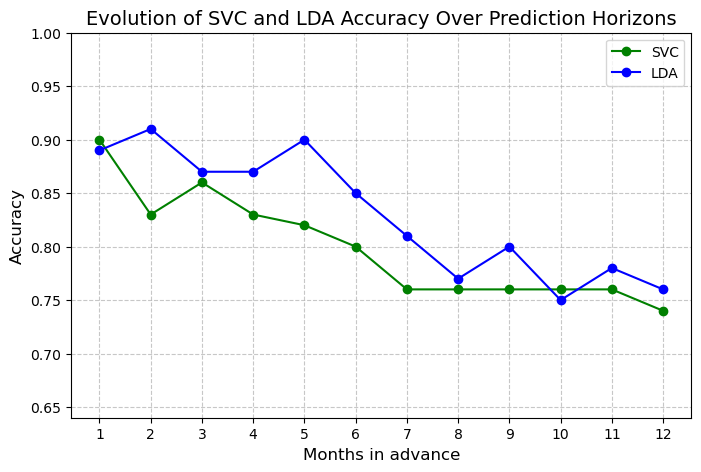

In [87]:
# Plot the evolution of accuracy
N = [i for i in range(1,n_months + 1)]
plt.figure(figsize=(8, 5))
plt.plot(N, list_test_accuracy_SVC, marker='o', color='green', label='SVC')
plt.plot(N, list_test_accuracy_LDA, marker='o', color='blue', label='LDA')


# Add details to the plot
plt.title('Evolution of SVC and LDA Accuracy Over Prediction Horizons', fontsize=14)
plt.xlabel('Months in advance', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(N)
plt.ylim(min(list_test_accuracy_SVC) - 0.1 , 1.0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)